<a href="https://colab.research.google.com/github/businsweetie/FinAnalyze/blob/main/article.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data

In [ ]:
! gdown --id 10goWdRlKe-WR9pf3qjm4Er5di2SbCqaK

Downloading...
From: https://drive.google.com/uc?id=10goWdRlKe-WR9pf3qjm4Er5di2SbCqaK
To: /content/credit_test.csv
100% 1.70M/1.70M [00:00<00:00, 111MB/s]


In [ ]:
! gdown --id 1WxoF0-_Z-cvdZAxVcHie-gN1_HZVsA99

Downloading...
From: https://drive.google.com/uc?id=1WxoF0-_Z-cvdZAxVcHie-gN1_HZVsA99
To: /content/credit_train.csv
100% 15.3M/15.3M [00:00<00:00, 62.2MB/s]


In [ ]:
!pip3 install category_encoders

     |████████████████████████████████| 82 kB 352 kB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import RandomizedSearchCV
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score # Функция для рассчета AUROC
from sklearn.metrics import roc_curve, precision_recall_curve, plot_precision_recall_curve # Функция для построения ROC-кривой
from sklearn.metrics import confusion_matrix  # функция расчета матрицы ошибок

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [ ]:
class ModelInspect(): # класс для оценки метрик модели
    def __init__(self, model, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = model.predict(X_test)
        self.probs = model.predict_proba(X_test)[:,1]
    
    def roc_curve_plot(self):
        fpr, tpr, threshold = roc_curve(self.y_test, self.probs)
        roc_auc = roc_auc_score(self.y_test, self.probs)

        plt.figure(figsize=(10,7))
        plt.plot([0, 1], label='Базисная линия', linestyle='--', color='lightskyblue')
        plt.plot(fpr, tpr, label = 'ROC-кривая', color='steelblue')
        plt.title('ROC AUC = %0.10f' % roc_auc, fontsize=12,  weight='bold')
        plt.ylabel('Доля верных положительных классификаций', fontsize=10)
        plt.xlabel('Доля ложных положительных классификаций', fontsize=10)
        plt.legend(loc = 'lower right')
        plt.show()
        print('Коэффициент Джини: ', 2 * roc_auc - 1)
    
    def confusion_matrix_plot(self):

        tn, fp, fn, tp = confusion_matrix(self.y_test, self.y_pred).ravel()
        cf_matrix = np.array([[tp,fp],[fn,tn]])
        group_names = ['TP','FP','FN','TN']
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)
        plt.figure(figsize=(5,4))
        sns.heatmap(cf_matrix, center=0, annot=labels, annot_kws={"size": 18}, fmt='', cmap= 'Blues', cbar = False, \
                 xticklabels = ['Дефолт','Не дефолт'], yticklabels= ['Дефолт','Не дефолт'])
        plt.title('Матрица ошибок', fontsize=12,  weight='bold')
        plt.xlabel('Фактические значения', fontsize=10)
        plt.ylabel('Предсказанные значение', fontsize=10)
        plt.show()
        
    def get_metrics(self):
        result = pd.Series({
            'accuracy' : accuracy_score(self.y_test, self.y_pred),
            'precision' : precision_score(self.y_test, self.y_pred),
            'recall' : recall_score(self.y_test, self.y_pred),
            'F1' : f1_score(self.y_test, self.y_pred),
            'ROC_AUC': roc_auc_score(self.y_test, self.probs) 
        })
        return result
    
    def recall_precision_plot(self):
        precisions, recalls, _ = precision_recall_curve(self.y_test, self.y_pred)
        ap = average_precision_score(self.y_test, self.y_pred)        
        
        plt.figure(figsize=(10,7))
        
        plt.step(recalls, precisions, color='steelblue', alpha=0.2, where='post')
        plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='steelblue')
        plt.xlabel('Полнота', fontsize=10);
        plt.ylabel('Точность', fontsize=10);
        plt.title('AUC PR = %0.10f' % ap, fontsize=12,  weight='bold')
        plt.grid(True)

        plt.show()

In [ ]:
class ModelInspectSVC(): # класс для оценки метрик модели
    def __init__(self, model, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = model.predict(X_test)
    
    def confusion_matrix_plot(self):

        tn, fp, fn, tp = confusion_matrix(self.y_test, self.y_pred).ravel()
        cf_matrix = np.array([[tp,fp],[fn,tn]])
        group_names = ['TP','FP','FN','TN']
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)
        plt.figure(figsize=(5,4))
        sns.heatmap(cf_matrix, center=0, annot=labels, annot_kws={"size": 18}, fmt='', cmap= 'Blues', cbar = False, \
                 xticklabels = ['Дефолт','Не дефолт'], yticklabels= ['Дефолт','Не дефолт'])
        plt.title('Матрица ошибок', fontsize=12,  weight='bold')
        plt.xlabel('Реальность', fontsize=10)
        plt.ylabel('Предсказания', fontsize=10)
        plt.show()
        
    def get_metrics(self):
        result = pd.Series({
            'accuracy' : accuracy_score(self.y_test, self.y_pred),
            'precision' : precision_score(self.y_test, self.y_pred),
            'recall' : recall_score(self.y_test, self.y_pred),
            'F1' : f1_score(self.y_test, self.y_pred)
        })
        return result
    
    def recall_precision_plot(self):
        precisions, recalls, _ = precision_recall_curve(self.y_test, self.y_pred)
        ap = average_precision_score(self.y_test, self.y_pred)        
        
        plt.figure(figsize=(10,7))
        
        plt.step(recalls, precisions, color='steelblue', alpha=0.2, where='post')
        plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='steelblue')
        plt.xlabel('Полнота', fontsize=10);
        plt.ylabel('Точность', fontsize=10);
        plt.title('AUC PR = %0.10f' % ap, fontsize=12,  weight='bold')
        plt.grid(True)

        plt.show()

In [ ]:
def coarse_classer(df, indexloc_1, indexloc_2):
    mean_val = pd.DataFrame(np.mean(pd.DataFrame([df.iloc[indexloc_1], df.iloc[indexloc_2]]))).T
    original = df.drop([indexloc_1, indexloc_2])
    
    coarsed_df = pd.concat([original, mean_val])
    coarsed_df = coarsed_df.sort_values(by='WoE', ascending=False).reset_index(drop=True)
    
    return coarsed_df

# Prep Data

In [ ]:
df_test = pd.read_csv('credit_test.csv')
df_train = pd.read_csv('credit_train.csv')
pd.set_option('display.max_columns', None)
df_train.head()

,id,application_dt,sample_cd,education_cd,gender_cd,age,car_own_flg,car_type_flg,appl_rej_cnt,good_work_flg,Score_bki,out_request_cnt,region_rating,home_address_cd,work_address_cd,income,SNA,first_time_cd,Air_flg
0,1,01JAN2014,train,SCH,M,27,Y,Y,0,0,-1.917831,0,40,2,3,32000,1,4,N
1,2,01JAN2014,train,GRD,F,26,N,N,0,0,-1.153144,2,60,2,3,50000,2,1,N
2,3,01JAN2014,train,SCH,M,35,N,N,0,1,-1.732810,0,40,1,2,20000,4,3,N
3,4,01JAN2014,train,GRD,F,35,N,N,0,1,-2.552133,2,20,2,3,80000,1,3,N
4,5,01JAN2014,train,UGR,F,24,N,N,0,0,-1.914581,1,50,2,3,27000,1,2,N


In [ ]:
df = df_train.merge(df_test, on='id', how='right')
df.head()

,id,application_dt,sample_cd,education_cd,gender_cd,age,car_own_flg,car_type_flg,appl_rej_cnt,good_work_flg,Score_bki,out_request_cnt,region_rating,home_address_cd,work_address_cd,income,SNA,first_time_cd,Air_flg,default_flg
0,1,01JAN2014,train,SCH,M,27,Y,Y,0,0,-1.917831,0,40,2,3,32000,1,4,N,0
1,2,01JAN2014,train,GRD,F,26,N,N,0,0,-1.153144,2,60,2,3,50000,2,1,N,0
2,3,01JAN2014,train,SCH,M,35,N,N,0,1,-1.732810,0,40,1,2,20000,4,3,N,0
3,4,01JAN2014,train,GRD,F,35,N,N,0,1,-2.552133,2,20,2,3,80000,1,3,N,0
4,5,01JAN2014,train,UGR,F,24,N,N,0,0,-1.914581,1,50,2,3,27000,1,2,N,0


In [ ]:
df['default_flg'].mean()

0.11522210423856295

In [ ]:
df.isna().mean()

id                 0.000000
application_dt     0.000000
sample_cd          0.000000
education_cd       0.003999
gender_cd          0.000000
age                0.000000
car_own_flg        0.000000
car_type_flg       0.000000
appl_rej_cnt       0.000000
good_work_flg      0.000000
Score_bki          0.000000
out_request_cnt    0.000000
region_rating      0.000000
home_address_cd    0.000000
work_address_cd    0.000000
income             0.000000
SNA                0.000000
first_time_cd      0.000000
Air_flg            0.000000
default_flg        0.000000
dtype: float64

In [ ]:
df = df.drop('id', 1)

In [ ]:
df = df.drop('application_dt', 1)

In [ ]:
df = df.drop('sample_cd', 1)

In [ ]:
col = ['client_education_cd',
       'client_gender_cd',
       'client_age_cnt',
       'car_own_flg',
       'car_type_flg',
       'refused_application_cnt',
       'good_work_flg',
       'client_score_bki_cnt',
       'out_request_cnt',
       'region_rating_cd',
       'client_home_address_cd',
       'client_work_address_cd',
       'client_income_cnt',
       'client_SNA_cd',
       'client_first_time_cd',
       'inter_passport_flg',
       'default_flg']
df.set_axis(col, axis='columns', inplace=True)

In [ ]:
df.head(2)

,client_education_cd,client_gender_cd,client_age_cnt,car_own_flg,car_type_flg,refused_application_cnt,good_work_flg,client_score_bki_cnt,out_request_cnt,region_rating_cd,client_home_address_cd,client_work_address_cd,client_income_cnt,client_SNA_cd,client_first_time_cd,inter_passport_flg,default_flg
0,SCH,M,27,Y,Y,0,0,-1.917831,0,40,2,3,32000,1,4,N,0
1,GRD,F,26,N,N,0,0,-1.153144,2,60,2,3,50000,2,1,N,0


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df.columns

Index(['client_education_cd', 'client_gender_cd', 'client_age_cnt',
       'car_own_flg', 'car_type_flg', 'refused_application_cnt',
       'good_work_flg', 'client_score_bki_cnt', 'out_request_cnt',
       'region_rating_cd', 'client_home_address_cd', 'client_work_address_cd',
       'client_income_cnt', 'client_SNA_cd', 'client_first_time_cd',
       'inter_passport_flg', 'default_flg'],
      dtype='object')

In [ ]:
X = df.drop(['default_flg'], axis=1)

In [ ]:
y = df['default_flg']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
df['default_flg'].value_counts()

0    159982
1     20834
Name: default_flg, dtype: int64

In [ ]:
(df['default_flg'].value_counts()[1] / df['default_flg'].value_counts().sum()) * 100

11.522210423856295

In [ ]:
(y_train.value_counts()[1] / y_train.value_counts().sum()) * 100

11.570580938761644

In [ ]:
(y_test.value_counts()[1] / y_test.value_counts().sum()) * 100

11.409346483546871

In [ ]:
df['default_flg'].value_counts()

0    159982
1     20834
Name: default_flg, dtype: int64

In [ ]:
y_train.value_counts()

0    111926
1     14645
Name: default_flg, dtype: int64

In [ ]:
y_test.value_counts()

0    48056
1     6189
Name: default_flg, dtype: int64

In [ ]:
X_train['default_flg'] = y_train

In [ ]:
X_test['default_flg'] = y_test

##Missing values

train

In [ ]:
X_train.isna().sum()

client_education_cd        511
client_gender_cd             0
client_age_cnt               0
car_own_flg                  0
car_type_flg                 0
refused_application_cnt      0
good_work_flg                0
client_score_bki_cnt         0
out_request_cnt              0
region_rating_cd             0
client_home_address_cd       0
client_work_address_cd       0
client_income_cnt            0
client_SNA_cd                0
client_first_time_cd         0
inter_passport_flg           0
default_flg                  0
dtype: int64

In [ ]:
X_train['client_education_cd'].value_counts()

SCH    62839
GRD    42820
UGR    17778
PGR     2256
ACD      367
Name: client_education_cd, dtype: int64

In [ ]:
X_train['client_education_cd'].fillna('SCH', inplace=True)
X_train['client_education_cd'].value_counts()

SCH    63350
GRD    42820
UGR    17778
PGR     2256
ACD      367
Name: client_education_cd, dtype: int64

In [ ]:
X_train.isna().sum()

client_education_cd        0
client_gender_cd           0
client_age_cnt             0
car_own_flg                0
car_type_flg               0
refused_application_cnt    0
good_work_flg              0
client_score_bki_cnt       0
out_request_cnt            0
region_rating_cd           0
client_home_address_cd     0
client_work_address_cd     0
client_income_cnt          0
client_SNA_cd              0
client_first_time_cd       0
inter_passport_flg         0
default_flg                0
dtype: int64

test

In [ ]:
X_test['client_education_cd'].value_counts()

SCH    27080
GRD    18364
UGR     7569
PGR      883
ACD      137
Name: client_education_cd, dtype: int64

In [ ]:
X_test['client_education_cd'].fillna('SCH', inplace=True)
X_test['client_education_cd'].value_counts()

SCH    27292
GRD    18364
UGR     7569
PGR      883
ACD      137
Name: client_education_cd, dtype: int64

##Prep Outliers

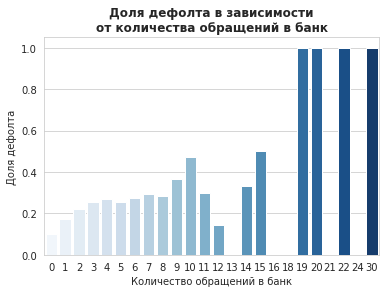

In [ ]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(6,4))
sns.set_style('whitegrid')

ax = sns.barplot(x="refused_application_cnt", y=y_train, data=X_train, palette='Blues', ci=None);
ax.set_title("Доля дефолта в зависимости\nот количества обращений в банк", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта", fontsize=10)
ax.set_xlabel("Количество обращений в банк", fontsize=10);

plt.show()

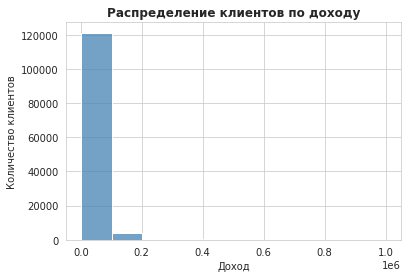

In [ ]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(6,4))
sns.set_style('whitegrid')

ax = sns.histplot(data=X_train, x="client_income_cnt", bins=10, color='steelblue');
ax.set_title("Распределение клиентов по доходу", fontsize=12,  weight='bold')
ax.set_ylabel("Количество клиентов", fontsize=10)
ax.set_xlabel("Доход", fontsize=10);

plt.show()

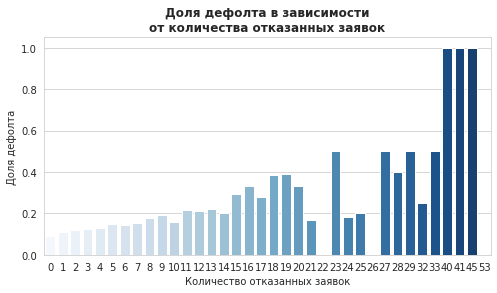

In [ ]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(8,4))
sns.set_style('whitegrid')

ax = sns.barplot(x="out_request_cnt", y=y_train, data=X_train, palette='Blues', ci=None);
ax.set_title("Доля дефолта в зависимости\nот количества отказанных заявок", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта", fontsize=10)
ax.set_xlabel("Количество отказанных заявок", fontsize=10);

###refused_application_cnt

train

In [ ]:
X_train['refused_application_cnt'].describe()

count    126571.000000
mean          0.281794
std           0.788017
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          30.000000
Name: refused_application_cnt, dtype: float64

In [ ]:
X_train['refused_application_cnt'].value_counts()

0     103948
1      15324
2       4432
3       1558
4        682
5        280
6        168
7         61
8         35
9         30
10        17
11        10
12         7
13         4
14         3
15         2
16         2
18         2
24         1
19         1
20         1
21         1
22         1
30         1
Name: refused_application_cnt, dtype: int64

In [ ]:
percentile25 = X_train['refused_application_cnt'].quantile(0.25)
percentile75 = X_train['refused_application_cnt'].quantile(0.75)

In [ ]:
iqr = percentile75 - percentile25

In [ ]:
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

In [ ]:
upper_limit

0.0

In [ ]:
lower_limit

0.0

In [ ]:
print("Highest allowed",X_train['refused_application_cnt'].mean() + 3*X_train['refused_application_cnt'].std())
print("Lowest allowed",X_train['refused_application_cnt'].mean() - 3*X_train['refused_application_cnt'].std())

Highest allowed 2.6458448916486303
Lowest allowed -2.082256075885146


In [ ]:
print("Highest allowed",X_train['refused_application_cnt'].quantile(0.99))
print("Lowest allowed",X_train['refused_application_cnt'].quantile(0.01))

Highest allowed 4.0
Lowest allowed 0.0


In [ ]:
upper_limit = X_train['refused_application_cnt'].quantile(0.99)
lower_limit = X_train['refused_application_cnt'].quantile(0.01)

In [ ]:
df.shape, X_train.shape, X_test.shape

((180816, 17), (126571, 17), (54245, 17))

In [ ]:
X_train = X_train[(X_train['refused_application_cnt'] <= upper_limit) & (X_train['refused_application_cnt'] >= lower_limit)]

In [ ]:
df.shape, X_train.shape, X_test.shape

((180816, 17), (125944, 17), (54245, 17))

In [ ]:
X_train['refused_application_cnt'].describe()

count    125944.000000
mean          0.250826
std           0.630476
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: refused_application_cnt, dtype: float64

In [ ]:
X_train['refused_application_cnt'].value_counts()

0    103948
1     15324
2      4432
3      1558
4       682
Name: refused_application_cnt, dtype: int64

test

In [ ]:
X_test = X_test[(X_test['refused_application_cnt'] <= upper_limit) & (X_test['refused_application_cnt'] >= lower_limit)]

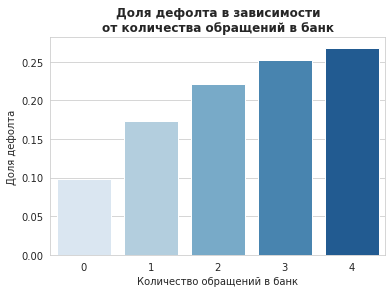

In [ ]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(6,4))
ax = sns.barplot(x="refused_application_cnt", y=y_train, data=X_train, palette='Blues', ci=None);
ax.set_title("Доля дефолта в зависимости\nот количества обращений в банк", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта", fontsize=10)
ax.set_xlabel("Количество обращений в банк", fontsize=10);

###out_request_cnt

In [ ]:
X_train['out_request_cnt'].describe()

count    125944.000000
mean          2.057057
std           2.152385
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          53.000000
Name: out_request_cnt, dtype: float64

In [ ]:
X_train['out_request_cnt'].value_counts()

1     30731
0     30304
2     24589
3     16891
4     10170
5      5877
6      3055
7      1553
8       831
9       526
10      406
11      305
12      208
13      163
14      112
15       57
16       38
18       24
17       18
19       15
21       11
20        9
23        9
22        8
24        8
25        5
28        5
26        4
27        4
32        3
45        1
29        1
33        1
41        1
53        1
Name: out_request_cnt, dtype: int64

In [ ]:
percentile25 = X_train['out_request_cnt'].quantile(0.25)
percentile75 = X_train['out_request_cnt'].quantile(0.75)

In [ ]:
iqr = percentile75 - percentile25

In [ ]:
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

In [ ]:
upper_limit

6.0

In [ ]:
lower_limit

-2.0

In [ ]:
print("Highest allowed",X_train['out_request_cnt'].mean() + 3*X_train['out_request_cnt'].std())
print("Lowest allowed",X_train['out_request_cnt'].mean() - 3*X_train['out_request_cnt'].std())

Highest allowed 8.51421290885072
Lowest allowed -4.400098699360789


In [ ]:
print("Highest allowed",X_train['out_request_cnt'].quantile(0.99))
print("Lowest allowed",X_train['out_request_cnt'].quantile(0.01))

Highest allowed 10.0
Lowest allowed 0.0


In [ ]:
X_train = X_train[(X_train['out_request_cnt'] <= upper_limit) & (X_train['out_request_cnt'] >= lower_limit)]

In [ ]:
X_train['out_request_cnt'].describe()

count    121617.000000
mean          1.800546
std           1.587400
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max           6.000000
Name: out_request_cnt, dtype: float64

In [ ]:
X_train['out_request_cnt'].value_counts()

1    30731
0    30304
2    24589
3    16891
4    10170
5     5877
6     3055
Name: out_request_cnt, dtype: int64

In [ ]:
X_test = X_test[(X_test['out_request_cnt'] <= upper_limit) & (X_test['out_request_cnt'] >= lower_limit)]

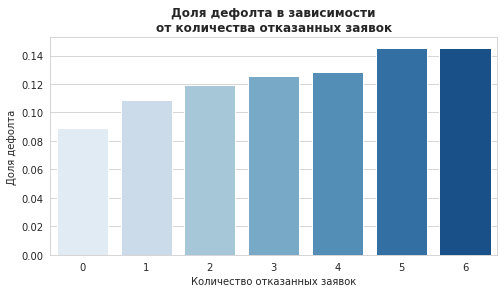

In [ ]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(8,4))
ax = sns.barplot(x="out_request_cnt", y=y_train, data=X_train, palette='Blues', ci=None);
ax.set_title("Доля дефолта в зависимости\nот количества отказанных заявок", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта", fontsize=10)
ax.set_xlabel("Количество отказанных заявок", fontsize=10);

###client_income_cnt

train

In [ ]:
X_train['client_income_cnt'].describe()

count     121617.000000
mean       40331.901050
std        41920.105279
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        47000.000000
max      1000000.000000
Name: client_income_cnt, dtype: float64

In [ ]:
percentile25 = X_train['client_income_cnt'].quantile(0.25)
percentile75 = X_train['client_income_cnt'].quantile(0.75)

In [ ]:
iqr = percentile75 - percentile25

In [ ]:
print("Highest allowed",percentile75 + 1.5 * iqr)
print("Lowest allowed",percentile25 - 1.5 * iqr)

Highest allowed 87500.0
Lowest allowed -20500.0


In [ ]:
print("Highest allowed",X_train['client_income_cnt'].mean() + 3*X_train['client_income_cnt'].std())
print("Lowest allowed",X_train['client_income_cnt'].mean() - 3*X_train['client_income_cnt'].std())

Highest allowed 166092.21688822372
Lowest allowed -85428.41478818834


In [ ]:
print("Highest allowed",X_train['client_income_cnt'].quantile(0.99))
print("Lowest allowed",X_train['client_income_cnt'].quantile(0.01))

Highest allowed 200000.0
Lowest allowed 6000.0


In [ ]:
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

In [ ]:
upper_limit

87500.0

In [ ]:
lower_limit

-20500.0

In [ ]:
X_train = X_train[(X_train['client_income_cnt'] <= upper_limit) & (X_train['client_income_cnt'] >= lower_limit)]

In [ ]:
X_train['client_income_cnt'].describe()

count    113315.000000
mean      32289.528271
std       17240.550009
min        1000.000000
25%       20000.000000
50%       30000.000000
75%       40000.000000
max       87500.000000
Name: client_income_cnt, dtype: float64

test

In [ ]:
X_test = X_test[(X_test['client_income_cnt'] <= upper_limit) & (X_test['client_income_cnt'] >= lower_limit)]

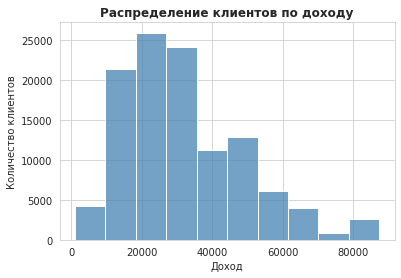

In [ ]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(6,4))
ax = sns.histplot(data=X_train, x="client_income_cnt", bins=10, color='steelblue');
ax.set_title("Распределение клиентов по доходу", fontsize=12,  weight='bold')
ax.set_ylabel("Количество клиентов", fontsize=10)
ax.set_xlabel("Доход", fontsize=10);

## Transform cont var into cat

In [ ]:
X_train.head()

,client_education_cd,client_gender_cd,client_age_cnt,car_own_flg,car_type_flg,refused_application_cnt,good_work_flg,client_score_bki_cnt,out_request_cnt,region_rating_cd,client_home_address_cd,client_work_address_cd,client_income_cnt,client_SNA_cd,client_first_time_cd,inter_passport_flg,default_flg
128387,SCH,M,57,N,N,0,0,-1.595450,1,60,2,3,20000,4,1,N,0
35202,SCH,M,30,Y,N,0,0,-1.294732,0,60,2,3,22000,1,3,N,1
144882,SCH,F,41,N,N,0,0,-1.738704,2,50,2,3,20000,2,3,N,0
27496,SCH,M,34,N,N,0,0,-1.976482,2,60,2,3,35000,1,3,N,0
6986,GRD,M,39,Y,N,0,0,-2.097774,0,60,1,2,30000,2,3,N,0


In [ ]:
pd.qcut(X_train['client_age_cnt'], 5)

128387    (51.0, 72.0]
35202     (28.0, 34.0]
144882    (34.0, 41.0]
27496     (28.0, 34.0]
6986      (34.0, 41.0]
              ...     
119879    (28.0, 34.0]
103694    (28.0, 34.0]
131932    (34.0, 41.0]
146867    (34.0, 41.0]
121958    (28.0, 34.0]
Name: client_age_cnt, Length: 113315, dtype: category
Categories (5, interval[float64]): [(20.999, 28.0] < (28.0, 34.0] < (34.0, 41.0] < (41.0, 51.0] <
                                    (51.0, 72.0]]

In [ ]:
X_train['client_age_cnt_bin'] = pd.qcut(X_train['client_age_cnt'], 5,
                                        labels=['lt_28', '28_to_34', '34_to_41', '41_to_51', 'gt_51'])

In [ ]:
X_train['client_age_cnt_bin'].value_counts()

lt_28       24078
28_to_34    23527
41_to_51    22732
34_to_41    21857
gt_51       21121
Name: client_age_cnt_bin, dtype: int64

In [ ]:
pd.qcut(X_train['client_score_bki_cnt'], 5)

128387    (-1.842, -1.541]
35202        (-1.541, 0.2]
144882    (-1.842, -1.541]
27496       (-2.1, -1.842]
6986        (-2.1, -1.842]
                ...       
119879      (-2.371, -2.1]
103694       (-1.541, 0.2]
131932    (-3.626, -2.371]
146867      (-2.1, -1.842]
121958    (-3.626, -2.371]
Name: client_score_bki_cnt, Length: 113315, dtype: category
Categories (5, interval[float64]): [(-3.626, -2.371] < (-2.371, -2.1] < (-2.1, -1.842] <
                                    (-1.842, -1.541] < (-1.541, 0.2]]

In [ ]:
X_train['client_score_bki_cnt_bin'] = pd.qcut(X_train['client_score_bki_cnt'], 5,
                                              labels=['less_-2.371', '-2.371_to_-2.1', '-2.1_to_-1.842',
                                             '-1.842_to_-1.541', 'more_-1.541'])

In [ ]:
X_train['client_score_bki_cnt_bin'].value_counts()

more_-1.541         22663
-1.842_to_-1.541    22663
-2.1_to_-1.842      22663
-2.371_to_-2.1      22663
less_-2.371         22663
Name: client_score_bki_cnt_bin, dtype: int64

test

In [ ]:
X_test['client_score_bki_cnt_bin'] = np.where(
            (X_test['client_score_bki_cnt'] <= -2.371),
            'less_-2.371',
            np.where(
                ((X_test['client_score_bki_cnt'] > -2.371) & (X_test['client_score_bki_cnt'] <= -2.1)),
                '-2.371_to_-2.1',
                np.where(
                    ((X_test['client_score_bki_cnt'] > -2.1) & (X_test['client_score_bki_cnt'] <= -1.842)),
                    '-2.1_to_-1.842',
                    np.where(
                        ((X_test['client_score_bki_cnt'] > -1.842) & (X_test['client_score_bki_cnt'] <= -1.541)),
                        '-1.842_to_-1.541',
                        np.where(
                        ((X_test['client_score_bki_cnt'] > -1.541)),
                        'more_-1.541',
                        X_test['client_score_bki_cnt']
                        )
                    )
                )
            )
      )

In [ ]:
X_test['client_score_bki_cnt_bin'].value_counts()

-2.371_to_-2.1      9878
less_-2.371         9868
-1.842_to_-1.541    9692
more_-1.541         9631
-2.1_to_-1.842      9586
Name: client_score_bki_cnt_bin, dtype: int64

train

In [ ]:
pd.qcut(X_train['client_income_cnt'], 5).value_counts()

(999.999, 18000.0]    25480
(18000.0, 25000.0]    25035
(33000.0, 45000.0]    22698
(45000.0, 87500.0]    22451
(25000.0, 33000.0]    17651
Name: client_income_cnt, dtype: int64

In [ ]:
X_train['client_income_cnt_bin'] = pd.qcut(X_train['client_income_cnt'], 5,
                                           labels=['less_18000', '18000_to_25000', '25000_to_33000', '33000_to_45000', 'more_45000'])

In [ ]:
X_train['client_income_cnt_bin'].value_counts()

less_18000        25480
18000_to_25000    25035
33000_to_45000    22698
more_45000        22451
25000_to_33000    17651
Name: client_income_cnt_bin, dtype: int64

test

In [ ]:
X_test['client_income_cnt_bin'] = np.where(
    (X_test['client_income_cnt'] <= 18000.0),
    '<18',
    np.where(
        ((X_test['client_income_cnt'] > 18000.0) & (X_test['client_income_cnt'] <= 25000.0)),
        '18_25',
        np.where(
            ((X_test['client_income_cnt'] > 25000.0) & (X_test['client_income_cnt'] <= 33000.0)),
            '25_33',
             np.where(
                 ((X_test['client_income_cnt'] > 33000.0) & (X_test['client_income_cnt'] <= 45000.0)),
                  '33_45',
                  np.where(
                      (X_test['client_income_cnt'] > 45000.0),
                       '>45',
                       X_test['client_income_cnt']
                       )
                   )
             )
        
))

In [ ]:
X_test['client_income_cnt_bin'].value_counts()

<18      10938
18_25    10769
33_45     9774
>45       9631
25_33     7543
Name: client_income_cnt_bin, dtype: int64

In [ ]:
X_train.head(5)

,client_education_cd,client_gender_cd,client_age_cnt,car_own_flg,car_type_flg,refused_application_cnt,good_work_flg,client_score_bki_cnt,out_request_cnt,region_rating_cd,client_home_address_cd,client_work_address_cd,client_income_cnt,client_SNA_cd,client_first_time_cd,inter_passport_flg,default_flg,client_age_cnt_bin,client_score_bki_cnt_bin,client_income_cnt_bin
128387,SCH,M,57,N,N,0,0,-1.595450,1,60,2,3,20000,4,1,N,0,gt_51,-1.842_to_-1.541,18000_to_25000
35202,SCH,M,30,Y,N,0,0,-1.294732,0,60,2,3,22000,1,3,N,1,28_to_34,more_-1.541,18000_to_25000
144882,SCH,F,41,N,N,0,0,-1.738704,2,50,2,3,20000,2,3,N,0,34_to_41,-1.842_to_-1.541,18000_to_25000
27496,SCH,M,34,N,N,0,0,-1.976482,2,60,2,3,35000,1,3,N,0,28_to_34,-2.1_to_-1.842,33000_to_45000
6986,GRD,M,39,Y,N,0,0,-2.097774,0,60,1,2,30000,2,3,N,0,34_to_41,-2.1_to_-1.842,25000_to_33000


#EDA

In [ ]:
X_train.groupby('client_education_cd')['default_flg'].agg(['count','mean'])

,count,mean
client_education_cd,,
ACD,235,0.046809
GRD,35615,0.078955
PGR,1523,0.049902
SCH,59486,0.139915
UGR,16456,0.116614


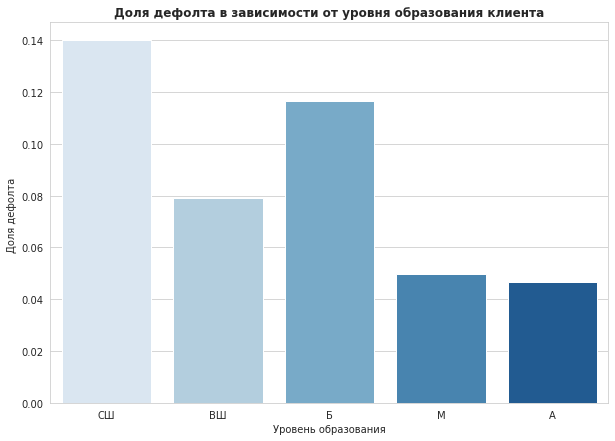

In [ ]:
plt.figure(figsize=(10,7))
ax = sns.barplot(x="client_education_cd", y="default_flg", data=X_train, palette='Blues', ci=None);
ax.set_title("Доля дефолта в зависимости от уровня образования клиента", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Уровень образования", fontsize=10);
ax.set_xticklabels(['СШ','ВШ', 'Б', 'М', 'А']);

In [ ]:
educ_bin =X_train.groupby('client_education_cd')['default_flg'].agg(['mean']).sort_values(by='mean', ascending=False)

In [ ]:
educ_bin

,mean
client_education_cd,
SCH,0.139915
UGR,0.116614
GRD,0.078955
PGR,0.049902
ACD,0.046809


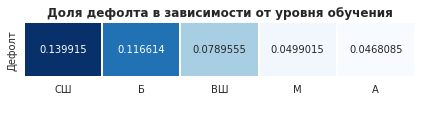

In [ ]:
plt.figure(figsize=(7,1))
ax = sns.heatmap(educ_bin.T, annot=True, fmt='.6g', cbar=False, cmap='Blues', linewidths=1);
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10)
ax.set_title("Доля дефолта в зависимости от уровня обучения", fontsize=12, weight='bold');
ax.set_xticklabels(['СШ', 'Б', 'ВШ', 'М', 'А']);
ax.set_yticklabels(['Дефолт'])
ax.set_xlabel(' ');

In [ ]:
X_train.groupby('client_gender_cd')['default_flg'].agg(['count','mean'])

,count,mean
client_gender_cd,,
F,66989,0.107913
M,46326,0.127617


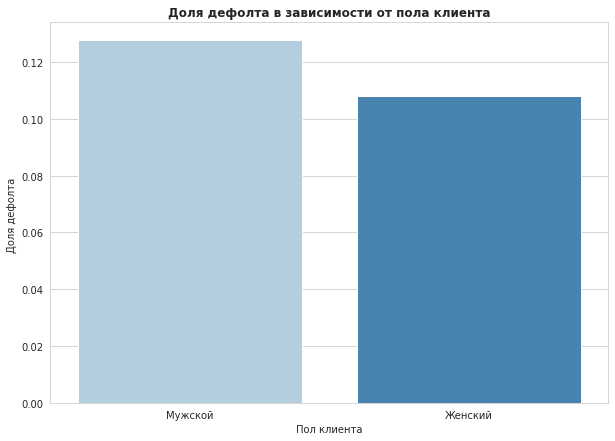

In [ ]:
plt.figure(figsize=(10,7))
ax = sns.barplot(x="client_gender_cd", y="default_flg", data=X_train, palette='Blues', ci=None);
ax.set_title("Доля дефолта в зависимости от пола клиента", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Пол клиента", fontsize=10);
ax.set_xticklabels(['Мужской','Женский']);

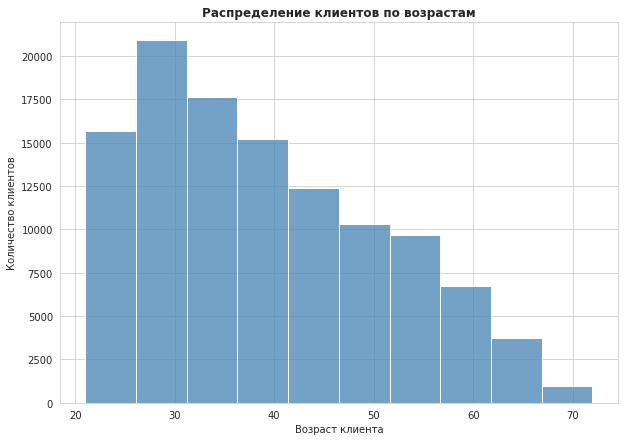

In [ ]:
plt.figure(figsize=(10,7))
sns.set_style('whitegrid')
ax = sns.histplot(data=X_train, x="client_age_cnt", bins=10, color='steelblue');
ax.set_title("Распределение клиентов по возрастам", fontsize=12,  weight='bold')
ax.set_ylabel("Количество клиентов", fontsize=10)
ax.set_xlabel("Возраст клиента", fontsize=10);

In [ ]:
age_bin =X_train.groupby('client_age_cnt_bin')['default_flg'].agg(['mean']) 

In [ ]:
age_bin

,mean
client_age_cnt_bin,
lt_28,0.128997
28_to_34,0.123688
34_to_41,0.113373
41_to_51,0.109581
gt_51,0.102079


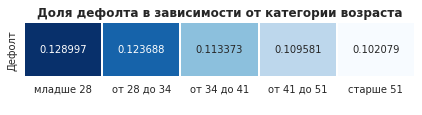

In [ ]:
plt.figure(figsize=(7,1))
ax = sns.heatmap(age_bin.T, annot=True, fmt='.6g', cbar=False, cmap='Blues', linewidths=1);
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10)
ax.set_title("Доля дефолта в зависимости от категории возраста", fontsize=12, weight='bold');
ax.set_xticklabels(['младше 28', 'от 28 до 34', 'от 34 до 41', 'от 41 до 51', 'старше 51']);
ax.set_yticklabels(['Дефолт'])
ax.set_xlabel(' ');

In [ ]:
age_bin = X_train.groupby('client_age_cnt_bin',dropna=False)['default_flg'].mean()

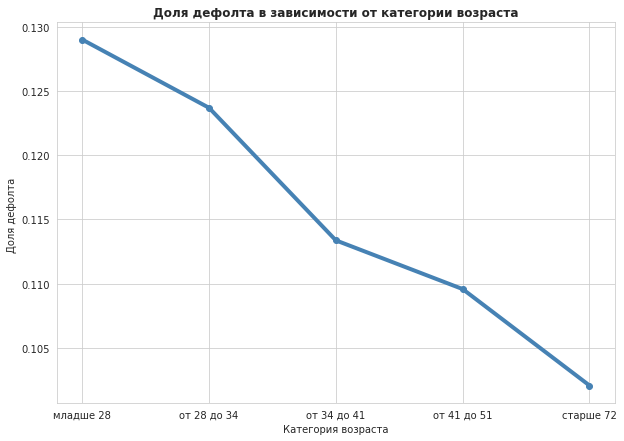

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(age_bin, color='steelblue', linewidth = 4, marker='o');
plt.title("Доля дефолта в зависимости от категории возраста", fontsize=12, weight='bold');
plt.ylabel("Доля дефолта ", fontsize=10);
plt.xlabel("Категория возраста", fontsize=10);

points = np.array([0, 1, 2, 3, 4])
labels = ['младше 28', 'от 28 до 34', 'от 34 до 41', 'от 41 до 51', 'старше 72']

plt.xticks(points, labels);
plt.show();

In [ ]:
X_train.groupby('car_own_flg', dropna=False)['default_flg'].agg(['count', 'mean'])

,count,mean
car_own_flg,,
N,80887,0.121725
Y,32428,0.101610


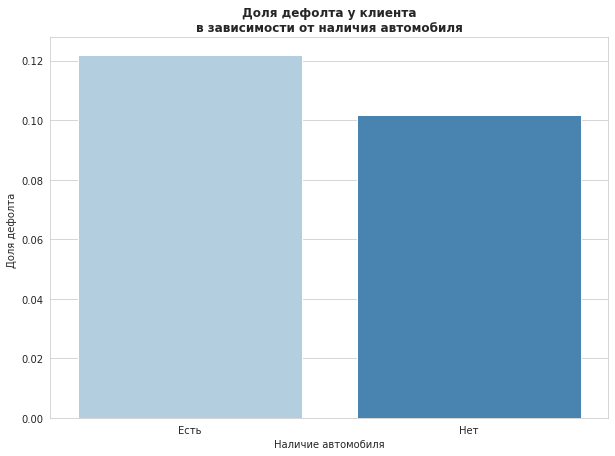

In [ ]:
plt.figure(figsize=(10,7))
ax = sns.barplot(x="car_own_flg", y="default_flg", data=X_train, palette='Blues', ci=None);
ax.set_title("Доля дефолта у клиента\nв зависимости от наличия автомобиля", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Наличие автомобиля", fontsize=10);
ax.set_xticklabels(['Есть','Нет']);

In [ ]:
X_train.groupby('car_type_flg', dropna=False)['default_flg'].agg(['count', 'mean'])

,count,mean
car_type_flg,,
N,96576,0.121904
Y,16739,0.081725


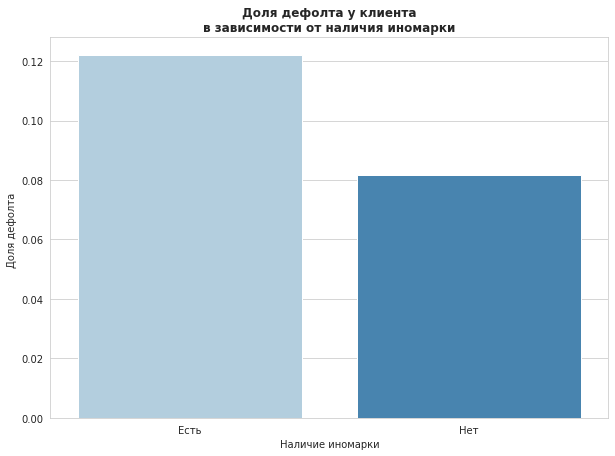

In [ ]:
plt.figure(figsize=(10,7))
ax = sns.barplot(x="car_type_flg", y="default_flg", data=X_train, palette='Blues', ci=None);
ax.set_title("Доля дефолта у клиента\nв зависимости от наличия иномарки", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Наличие иномарки", fontsize=10);
ax.set_xticklabels(['Есть','Нет']);

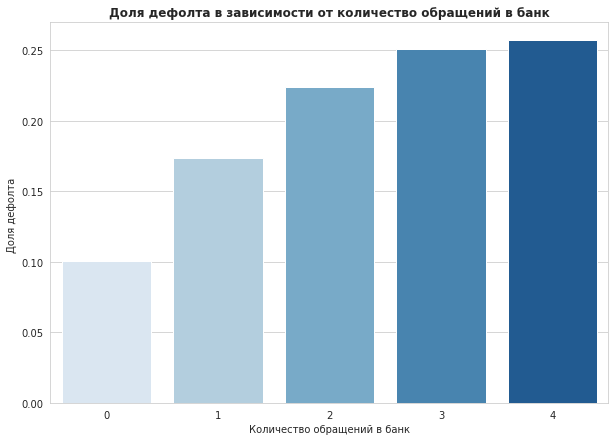

In [ ]:
plt.figure(figsize=(10,7))
ax = sns.barplot(x="refused_application_cnt", y="default_flg", data=X_train, palette='Blues', ci=None);
ax.set_title("Доля дефолта в зависимости от количество обращений в банк", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Количество обращений в банк", fontsize=10);

In [ ]:
ref_app =X_train.groupby('refused_application_cnt')['default_flg'].agg(['mean']).sort_values(ascending=False, by='mean')

In [ ]:
ref_app

,mean
refused_application_cnt,
4,0.256897
3,0.250923
2,0.224191
1,0.173872
0,0.100237


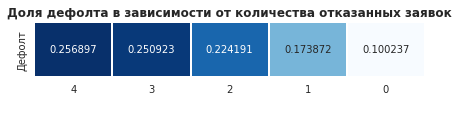

In [ ]:
plt.figure(figsize=(7,1))
ax = sns.heatmap(ref_app.T, annot=True, fmt='.6g', cbar=False, cmap='Blues', linewidths=1);
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10)
ax.set_title("Доля дефолта в зависимости от количества отказанных заявок", fontsize=12, weight='bold');
ax.set_xticklabels(['4', '3', '2', '1', '0']);
ax.set_yticklabels(['Дефолт'])
ax.set_xlabel(' ');

In [ ]:
X_train.groupby('good_work_flg')['default_flg'].agg(['count', 'mean'])

,count,mean
good_work_flg,,
0,94879,0.122714
1,18436,0.081254


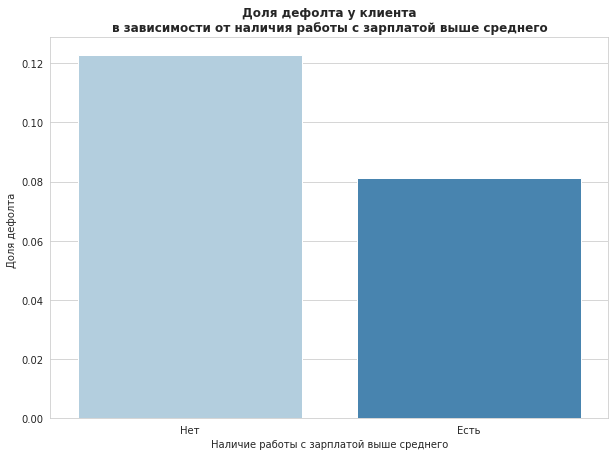

In [ ]:
plt.figure(figsize=(10,7))
ax = sns.barplot(x="good_work_flg", y="default_flg", data=X_train, palette='Blues', ci=None);
ax.set_title("Доля дефолта у клиента\nв зависимости от наличия работы с зарплатой выше среднего", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Наличие работы с зарплатой выше среднего", fontsize=10);
ax.set_xticklabels(['Нет','Есть']);

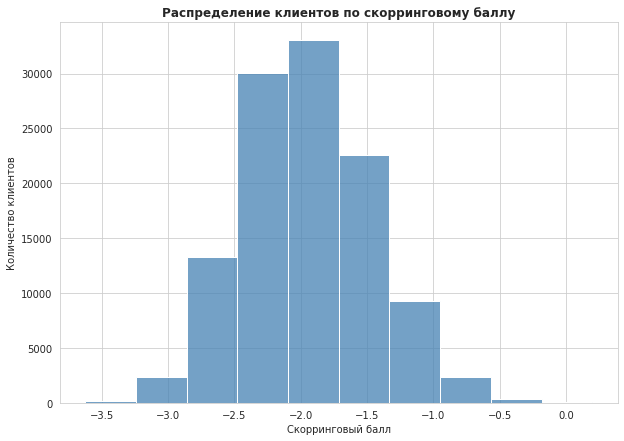

In [ ]:
plt.figure(figsize=(10,7))
sns.set_style('whitegrid')
ax = sns.histplot(data=X_train, x="client_score_bki_cnt", bins=10, color='steelblue');
ax.set_title("Распределение клиентов по скорринговому баллу", fontsize=12,  weight='bold')
ax.set_ylabel("Количество клиентов", fontsize=10)
ax.set_xlabel("Скорринговый балл", fontsize=10);

In [ ]:
X_train.groupby('client_score_bki_cnt_bin')['default_flg'].agg(['count', 'mean'])

,count,mean
client_score_bki_cnt_bin,,
less_-2.371,22663,0.054582
-2.371_to_-2.1,22663,0.079072
-2.1_to_-1.842,22663,0.102899
-1.842_to_-1.541,22663,0.139302
more_-1.541,22663,0.203989


In [ ]:
score_bki =X_train.groupby('client_score_bki_cnt_bin')['default_flg'].agg(['mean']).sort_values(ascending=False, by='mean')

In [ ]:
score_bki

,mean
client_score_bki_cnt_bin,
more_-1.541,0.203989
-1.842_to_-1.541,0.139302
-2.1_to_-1.842,0.102899
-2.371_to_-2.1,0.079072
less_-2.371,0.054582


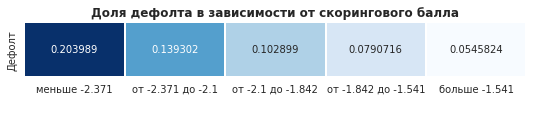

In [ ]:
plt.figure(figsize=(9,1))
ax = sns.heatmap(score_bki.T, annot=True, fmt='.6g', cbar=False, cmap='Blues', linewidths=1);
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10)
ax.set_title("Доля дефолта в зависимости от скорингового балла", fontsize=12, weight='bold');
ax.set_xticklabels(['меньше -2.371', 'от -2.371 до -2.1', 'от -2.1 до -1.842', 'от -1.842 до -1.541', 'больше -1.541']);
ax.set_yticklabels(['Дефолт'])
ax.set_xlabel(' ');

In [ ]:
score_bki_bin = X_train.groupby('client_score_bki_cnt_bin')['default_flg'].mean()

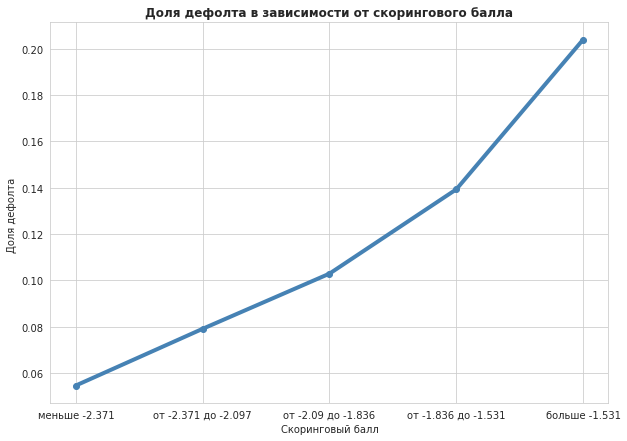

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(score_bki_bin, color='steelblue', linewidth = 4, marker='o');
plt.title("Доля дефолта в зависимости от скорингового балла", fontsize=12, weight='bold');
plt.ylabel("Доля дефолта ", fontsize=10);
plt.xlabel("Скоринговый балл", fontsize=10);

points = np.array([0, 1, 2, 3, 4])
labels = ['меньше -2.371', 'от -2.371 до -2.097', 'от -2.09 до -1.836', 'от -1.836 до -1.531', 'больше -1.531']

plt.xticks(points, labels);
plt.show();

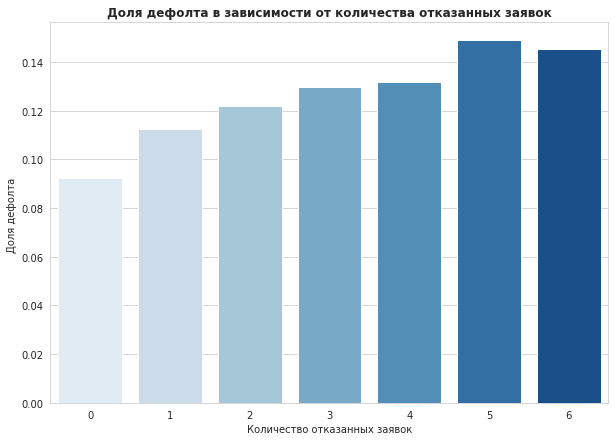

In [ ]:
plt.figure(figsize=(10,7))
ax = sns.barplot(x="out_request_cnt", y="default_flg", data=X_train, palette='Blues', ci=None);
ax.set_title("Доля дефолта в зависимости от количества отказанных заявок", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Количество отказанных заявок", fontsize=10);

In [ ]:
X_train.groupby('region_rating_cd')['default_flg'].agg(['count', 'mean'])

,count,mean
region_rating_cd,,
20,387,0.193798
30,440,0.190909
40,18466,0.155692
50,42964,0.122731
60,25180,0.112986
70,9196,0.090909
80,16682,0.069116


In [ ]:
region_rating = X_train.groupby('region_rating_cd')['default_flg'].mean()

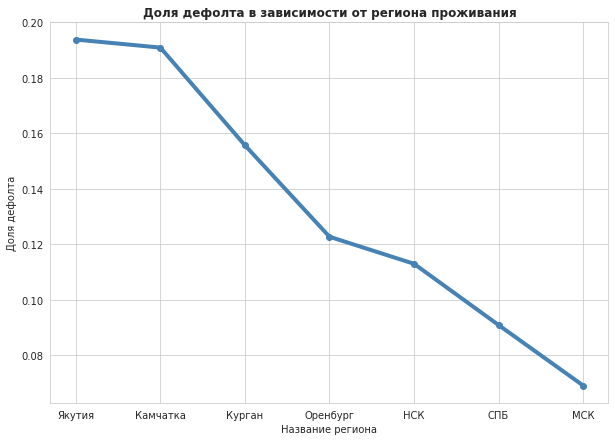

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(region_rating, color='steelblue', linewidth = 4, marker='o');
plt.title("Доля дефолта в зависимости от региона проживания", fontsize=12, weight='bold')
plt.ylabel("Доля дефолта", fontsize=10)
plt.xlabel("Название региона", fontsize=10);

points = np.array([20, 30, 40, 50, 60, 70, 80])
labels = ['Якутия','Камчатка','Курган','Оренбург','НСК','СПБ','МСК']

plt.xticks(points, labels);
plt.show();

In [ ]:
X_train.groupby('client_home_address_cd')['default_flg'].agg(['count', 'mean'])

,count,mean
client_home_address_cd,,
1,40235,0.088580
2,71511,0.131406
3,1569,0.114723


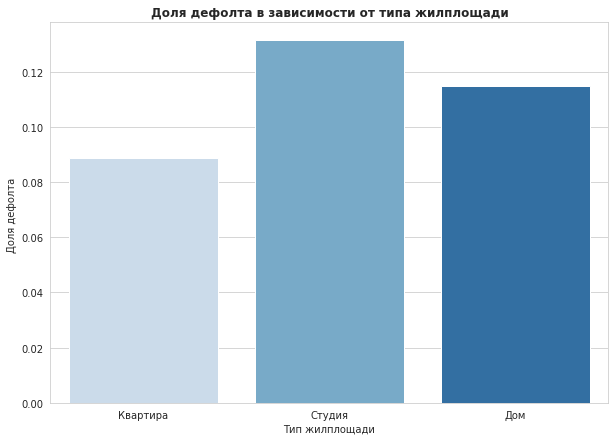

In [ ]:
plt.figure(figsize=(10,7))
ax = sns.barplot(x="client_home_address_cd", y="default_flg", data=X_train, palette='Blues', ci=None);
ax.set_title("Доля дефолта в зависимости от типа жилплощади", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Тип жилплощади", fontsize=10);
ax.set_xticklabels(['Квартира','Студия','Дом']);

In [ ]:
X_train.groupby('client_work_address_cd')['default_flg'].agg(['count', 'mean'])

,count,mean
client_work_address_cd,,
1,10483,0.071831
2,25466,0.095186
3,77366,0.128790


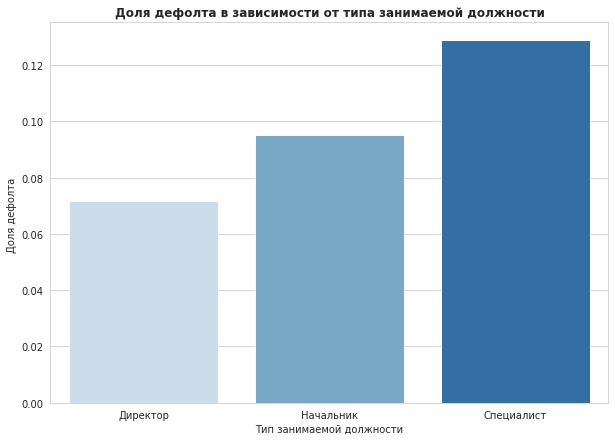

In [ ]:
plt.figure(figsize=(10,7))
ax = sns.barplot(x="client_work_address_cd", y="default_flg", data=X_train, palette='Blues', ci=None);
ax.set_title("Доля дефолта в зависимости от типа занимаемой должности", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Тип занимаемой должности", fontsize=10);
ax.set_xticklabels(['Директор','Начальник','Специалист']);

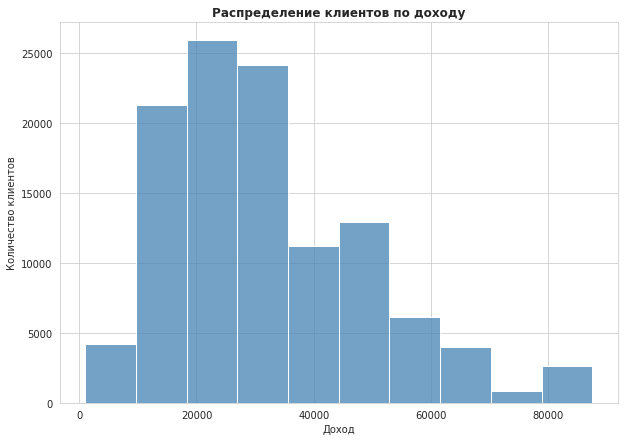

In [ ]:
plt.figure(figsize=(10,7))
sns.set_style('whitegrid')
ax = sns.histplot(data=X_train, x="client_income_cnt", bins=10, color='steelblue');
ax.set_title("Распределение клиентов по доходу", fontsize=12,  weight='bold')
ax.set_ylabel("Количество клиентов", fontsize=10)
ax.set_xlabel("Доход", fontsize=10);

In [ ]:
income_bin = X_train.groupby('client_income_cnt_bin')['default_flg'].mean()

In [ ]:
X_train.groupby('client_income_cnt_bin')['default_flg'].mean()

client_income_cnt_bin
less_18000        0.130298
18000_to_25000    0.130617
25000_to_33000    0.118803
33000_to_45000    0.112345
more_45000        0.084807
Name: default_flg, dtype: float64

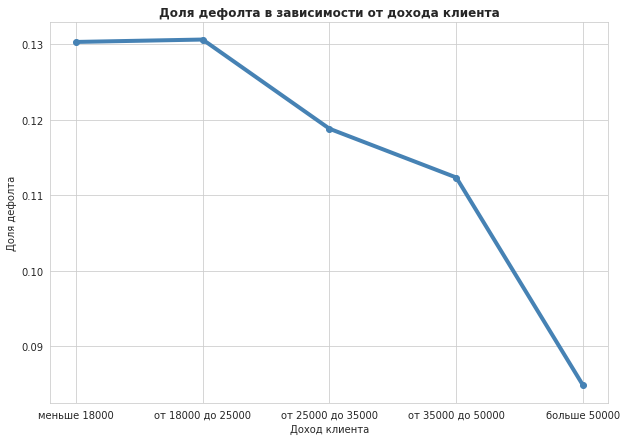

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(income_bin, color='steelblue', linewidth = 4, marker='o');
plt.title("Доля дефолта в зависимости от дохода клиента", fontsize=12, weight='bold')
plt.ylabel("Доля дефолта", fontsize=10)
plt.xlabel("Доход клиента", fontsize=10);

points = np.array([0, 1, 2, 3, 4])
labels = ['меньше 18000','от 18000 до 25000','от 25000 до 35000','от 35000 до 50000','больше 50000']

plt.xticks(points, labels);
plt.show();

In [ ]:
X_train.groupby('client_SNA_cd')['default_flg'].agg(['count', 'mean'])

,count,mean
client_SNA_cd,,
1,71297,0.090200
2,16694,0.130286
3,6530,0.149770
4,18794,0.189263


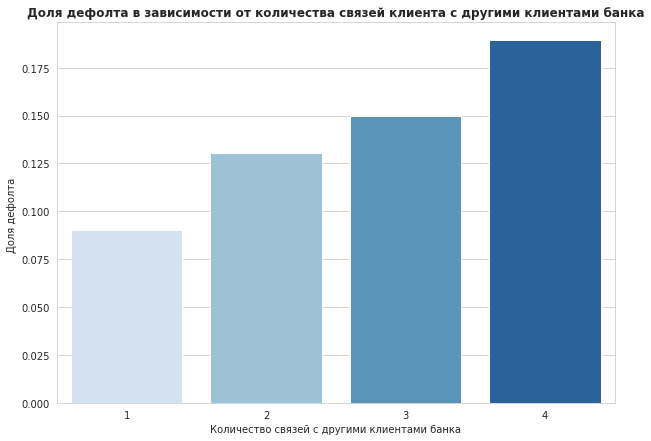

In [ ]:
plt.figure(figsize=(10,7))
ax = sns.barplot(x="client_SNA_cd", y="default_flg", data=X_train, palette='Blues', ci=None);
ax.set_title("Доля дефолта в зависимости от количества связей клиента с другими клиентами банка", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Количество связей с другими клиентами банка", fontsize=10);

In [ ]:
X_train.groupby('client_first_time_cd')['default_flg'].agg(['count', 'mean'])

,count,mean
client_first_time_cd,,
1,20205,0.164464
2,17267,0.140905
3,46564,0.110278
4,29279,0.076847


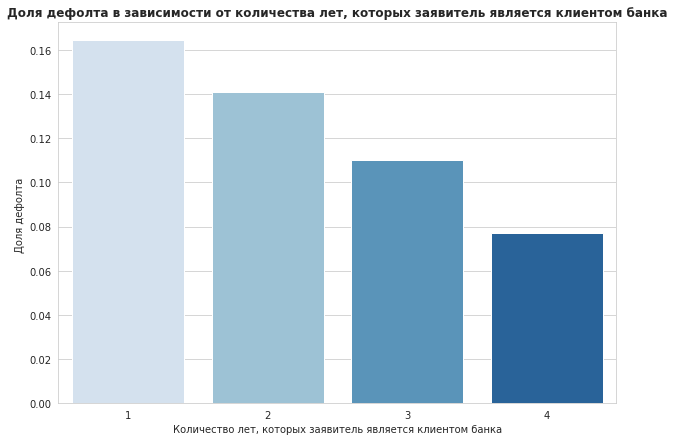

In [ ]:
plt.figure(figsize=(10,7))
ax = sns.barplot(x="client_first_time_cd", y="default_flg", data=X_train, palette='Blues', ci=None);
ax.set_title("Доля дефолта в зависимости от количества лет, которых заявитель является клиентом банка", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Количество лет, которых заявитель является клиентом банка", fontsize=10);

In [ ]:
X_train.groupby('inter_passport_flg')['default_flg'].agg(['count', 'mean'])

,count,mean
inter_passport_flg,,
N,97600,0.123258
Y,15715,0.070697


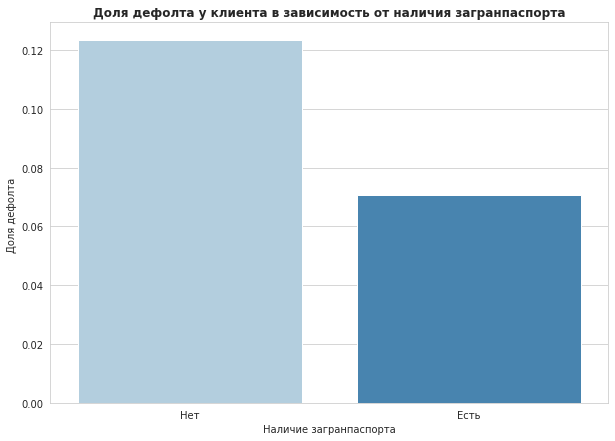

In [ ]:
plt.figure(figsize=(10,7))
ax = sns.barplot(x="inter_passport_flg", y="default_flg", data=X_train, palette='Blues', ci=None);
ax.set_title("Доля дефолта у клиента в зависимость от наличия загранпаспорта", fontsize=12, weight='bold')
ax.set_ylabel("Доля дефолта ", fontsize=10)
ax.set_xlabel("Наличие загранпаспорта", fontsize=10);
ax.set_xticklabels(['Нет','Есть']);

## WoE and IV

In [ ]:
X_train.shape

(113315, 20)

In [ ]:
y_train.shape

(126571,)

In [ ]:
X_train.columns

Index(['client_education_cd', 'client_gender_cd', 'client_age_cnt',
       'car_own_flg', 'car_type_flg', 'refused_application_cnt',
       'good_work_flg', 'client_score_bki_cnt', 'out_request_cnt',
       'region_rating_cd', 'client_home_address_cd', 'client_work_address_cd',
       'client_income_cnt', 'client_SNA_cd', 'client_first_time_cd',
       'inter_passport_flg', 'default_flg', 'client_age_cnt_bin',
       'client_score_bki_cnt_bin', 'client_income_cnt_bin'],
      dtype='object')

In [ ]:
colname = ['client_education_cd', 'client_gender_cd',
       'car_own_flg', 'car_type_flg', 'refused_application_cnt',
       'good_work_flg', 'out_request_cnt',
       'region_rating_cd', 'client_home_address_cd', 'client_work_address_cd',
       'client_SNA_cd', 'client_first_time_cd',
       'inter_passport_flg','client_age_cnt_bin',
       'client_score_bki_cnt_bin', 'client_income_cnt_bin', 'default_flg']

In [ ]:
for col in X_train[colname]:
    if col == 'default_flg': continue
    else:
        print('WoE and IV for column: {}'.format(col))
        dataf, iv = calculate_woe_iv(X_train[colname], col, 'default_flg')
        print(dataf)
        print('IV score: {:.2f}'.format(iv))
        print('\n')

WoE and IV for column: client_education_cd
  Value    All   Good   Bad  Distr_Good  Distr_Bad       WoE        IV
0   SCH  59486  51163  8323    0.510741   0.633361 -0.215178  0.026385
2   UGR  16456  14537  1919    0.145117   0.146032 -0.006279  0.000006
1   GRD  35615  32803  2812    0.327460   0.213987  0.425452  0.048278
3   PGR   1523   1447    76    0.014445   0.005783  0.915343  0.007928
4   ACD    235    224    11    0.002236   0.000837  0.982579  0.001375
IV score: 0.08


WoE and IV for column: client_gender_cd
  Value    All   Good   Bad  Distr_Good  Distr_Bad       WoE        IV
0     M  46326  40414  5912    0.403438    0.44989 -0.108979  0.005062
1     F  66989  59760  7229    0.596562    0.55011  0.081064  0.003766
IV score: 0.01


WoE and IV for column: car_own_flg
  Value    All   Good   Bad  Distr_Good  Distr_Bad       WoE        IV
0     N  80887  71041  9846    0.709176   0.749258 -0.054980  0.002204
1     Y  32428  29133  3295    0.290824   0.250742  0.148294  0.005

Таблица для интерпретации IV:

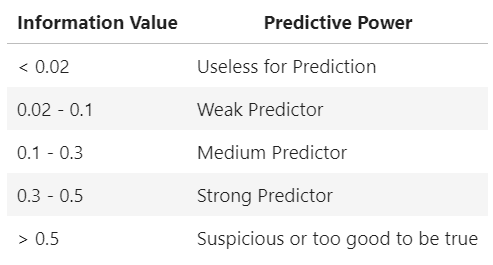

In [ ]:
woe_iv_cols = ['refused_application_cnt',
               'client_first_time_cd',
               'client_score_bki_cnt',
               'client_SNA_cd',
               'client_education_cd',
               'region_rating_cd',
               'client_income_cnt',
               'inter_passport_flg',
               'client_work_address_cd',
               'default_flg']

In [ ]:
X_train_prep = X_train[woe_iv_cols].copy()

In [ ]:
X_test_prep = X_test[woe_iv_cols].copy()

In [ ]:
X_train_prep.head()

,refused_application_cnt,client_first_time_cd,client_score_bki_cnt,client_SNA_cd,client_education_cd,region_rating_cd,client_income_cnt,inter_passport_flg,client_work_address_cd,default_flg
128387,0,1,-1.595450,4,SCH,60,20000,N,3,0
35202,0,3,-1.294732,1,SCH,60,22000,N,3,1
144882,0,3,-1.738704,2,SCH,50,20000,N,3,0
27496,0,3,-1.976482,1,SCH,60,35000,N,3,0
6986,0,3,-2.097774,2,GRD,60,30000,N,2,0


## OHE

In [ ]:
X_train_prep.columns

Index(['refused_application_cnt', 'client_first_time_cd',
       'client_score_bki_cnt', 'client_SNA_cd', 'client_education_cd',
       'region_rating_cd', 'client_income_cnt', 'inter_passport_flg',
       'client_work_address_cd', 'default_flg'],
      dtype='object')

In [ ]:
OHE = ce.OneHotEncoder(cols=['client_education_cd', 'inter_passport_flg', 'client_work_address_cd'], use_cat_names=True, handle_unknown='ignore')

In [ ]:
X_train_prep = OHE.fit_transform(X_train_prep)

In [ ]:
X_test_prep = OHE.fit_transform(X_test_prep)

In [ ]:
X_train_prep.head()

,refused_application_cnt,client_first_time_cd,client_score_bki_cnt,client_SNA_cd,client_education_cd_SCH,client_education_cd_GRD,client_education_cd_UGR,client_education_cd_PGR,client_education_cd_ACD,region_rating_cd,client_income_cnt,inter_passport_flg_N,inter_passport_flg_Y,client_work_address_cd_3.0,client_work_address_cd_2.0,client_work_address_cd_1.0,default_flg
128387,0,1,-1.595450,4,1,0,0,0,0,60,20000,1,0,1,0,0,0
35202,0,3,-1.294732,1,1,0,0,0,0,60,22000,1,0,1,0,0,1
144882,0,3,-1.738704,2,1,0,0,0,0,50,20000,1,0,1,0,0,0
27496,0,3,-1.976482,1,1,0,0,0,0,60,35000,1,0,1,0,0,0
6986,0,3,-2.097774,2,0,1,0,0,0,60,30000,1,0,0,1,0,0


In [ ]:
X_test_prep.head()

,refused_application_cnt,client_first_time_cd,client_score_bki_cnt,client_SNA_cd,client_education_cd_SCH,client_education_cd_GRD,client_education_cd_UGR,client_education_cd_PGR,client_education_cd_ACD,region_rating_cd,client_income_cnt,inter_passport_flg_N,inter_passport_flg_Y,client_work_address_cd_3.0,client_work_address_cd_2.0,client_work_address_cd_1.0,default_flg
30601,0,1,-0.907830,4,1,0,0,0,0,70,30000,1,0,1,0,0,1
23455,1,4,-1.991432,1,1,0,0,0,0,60,25000,1,0,0,1,0,0
91238,1,2,-1.775263,4,0,1,0,0,0,50,15000,1,0,1,0,0,0
9208,0,4,-2.607149,3,1,0,0,0,0,50,15000,1,0,0,1,0,0
50444,0,3,-1.815915,1,0,0,1,0,0,70,60000,1,0,0,0,1,1


In [ ]:
X_train_prep['client_education_cd'] = X_train['client_education_cd'].copy()
X_train_prep['inter_passport_flg'] = X_train['inter_passport_flg'].copy()
X_train_prep['client_work_address_cd'] = X_train['client_work_address_cd'].copy()

In [ ]:
X_test_prep['client_education_cd'] = X_test['client_education_cd'].copy()
X_test_prep['inter_passport_flg'] = X_test['inter_passport_flg'].copy()
X_test_prep['client_work_address_cd'] = X_test['client_work_address_cd'].copy()

In [ ]:
X_train_prep.head(5)

,refused_application_cnt,client_first_time_cd,client_score_bki_cnt,client_SNA_cd,client_education_cd_SCH,client_education_cd_GRD,client_education_cd_UGR,client_education_cd_PGR,client_education_cd_ACD,region_rating_cd,client_income_cnt,inter_passport_flg_N,inter_passport_flg_Y,client_work_address_cd_3.0,client_work_address_cd_2.0,client_work_address_cd_1.0,default_flg,client_education_cd,inter_passport_flg,client_work_address_cd
128387,0,1,-1.595450,4,1,0,0,0,0,60,20000,1,0,1,0,0,0,SCH,N,3
35202,0,3,-1.294732,1,1,0,0,0,0,60,22000,1,0,1,0,0,1,SCH,N,3
144882,0,3,-1.738704,2,1,0,0,0,0,50,20000,1,0,1,0,0,0,SCH,N,3
27496,0,3,-1.976482,1,1,0,0,0,0,60,35000,1,0,1,0,0,0,SCH,N,3
6986,0,3,-2.097774,2,0,1,0,0,0,60,30000,1,0,0,1,0,0,GRD,N,2


In [ ]:
X_test_prep.head(5)

,refused_application_cnt,client_first_time_cd,client_score_bki_cnt,client_SNA_cd,client_education_cd_SCH,client_education_cd_GRD,client_education_cd_UGR,client_education_cd_PGR,client_education_cd_ACD,region_rating_cd,client_income_cnt,inter_passport_flg_N,inter_passport_flg_Y,client_work_address_cd_3.0,client_work_address_cd_2.0,client_work_address_cd_1.0,default_flg,client_education_cd,inter_passport_flg,client_work_address_cd
30601,0,1,-0.907830,4,1,0,0,0,0,70,30000,1,0,1,0,0,1,SCH,N,3
23455,1,4,-1.991432,1,1,0,0,0,0,60,25000,1,0,0,1,0,0,SCH,N,2
91238,1,2,-1.775263,4,0,1,0,0,0,50,15000,1,0,1,0,0,0,GRD,N,3
9208,0,4,-2.607149,3,1,0,0,0,0,50,15000,1,0,0,1,0,0,SCH,N,2
50444,0,3,-1.815915,1,0,0,1,0,0,70,60000,1,0,0,0,1,1,UGR,N,1


## TargetEncoder

In [ ]:
y_train = X_train_prep['default_flg']

In [ ]:
y_test = X_test_prep['default_flg']

In [ ]:
TE = ce.TargetEncoder(cols=['client_education_cd', 'inter_passport_flg', 'client_work_address_cd'])

In [ ]:
X_train_prep = TE.fit_transform(X_train_prep, y_train)

In [ ]:
X_test_prep = TE.fit_transform(X_test_prep, y_test)

In [ ]:
X_train_prep.head()

,refused_application_cnt,client_first_time_cd,client_score_bki_cnt,client_SNA_cd,client_education_cd_SCH,client_education_cd_GRD,client_education_cd_UGR,client_education_cd_PGR,client_education_cd_ACD,region_rating_cd,client_income_cnt,inter_passport_flg_N,inter_passport_flg_Y,client_work_address_cd_3.0,client_work_address_cd_2.0,client_work_address_cd_1.0,default_flg,client_education_cd,inter_passport_flg,client_work_address_cd
128387,0,1,-1.595450,4,1,0,0,0,0,60,20000,1,0,1,0,0,0,0.139915,0.123258,0.128790
35202,0,3,-1.294732,1,1,0,0,0,0,60,22000,1,0,1,0,0,1,0.139915,0.123258,0.128790
144882,0,3,-1.738704,2,1,0,0,0,0,50,20000,1,0,1,0,0,0,0.139915,0.123258,0.128790
27496,0,3,-1.976482,1,1,0,0,0,0,60,35000,1,0,1,0,0,0,0.139915,0.123258,0.128790
6986,0,3,-2.097774,2,0,1,0,0,0,60,30000,1,0,0,1,0,0,0.078955,0.123258,0.095186


## Scale

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train_prep.columns

Index(['refused_application_cnt', 'client_first_time_cd',
       'client_score_bki_cnt', 'client_SNA_cd', 'client_education_cd_SCH',
       'client_education_cd_GRD', 'client_education_cd_UGR',
       'client_education_cd_PGR', 'client_education_cd_ACD',
       'region_rating_cd', 'client_income_cnt', 'inter_passport_flg_N',
       'inter_passport_flg_Y', 'client_work_address_cd_3.0',
       'client_work_address_cd_2.0', 'client_work_address_cd_1.0',
       'default_flg', 'client_education_cd', 'inter_passport_flg',
       'client_work_address_cd'],
      dtype='object')

In [ ]:
scaler.fit(np.array(X_train_prep[['refused_application_cnt', 'client_first_time_cd', 'client_score_bki_cnt',
                                 'client_SNA_cd', 'region_rating_cd', 'client_income_cnt']]).reshape(-1,1))
# transform the data
X_train_prep['refused_application_cnt'] = scaler.transform(np.array(X_train_prep['refused_application_cnt']).reshape(-1,1))
X_train_prep['client_first_time_cd'] = scaler.transform(np.array(X_train_prep['client_first_time_cd']).reshape(-1,1))
X_train_prep['client_SNA_cd'] = scaler.transform(np.array(X_train_prep['client_SNA_cd']).reshape(-1,1))
X_train_prep['region_rating_cd'] = scaler.transform(np.array(X_train_prep['region_rating_cd']).reshape(-1,1))
X_train_prep['client_score_bki_cnt'] = scaler.transform(np.array(X_train_prep['client_score_bki_cnt']).reshape(-1,1))
X_train_prep['client_income_cnt'] = scaler.transform(np.array(X_train_prep['client_income_cnt']).reshape(-1,1))

In [ ]:
scaler.fit(np.array(X_test_prep[['refused_application_cnt', 'client_first_time_cd', 'client_score_bki_cnt',
                                 'client_SNA_cd', 'region_rating_cd', 'client_income_cnt']]).reshape(-1,1))
# transform the data
X_test_prep['refused_application_cnt'] = scaler.transform(np.array(X_test_prep['refused_application_cnt']).reshape(-1,1))
X_test_prep['client_first_time_cd'] = scaler.transform(np.array(X_test_prep['client_first_time_cd']).reshape(-1,1))
X_test_prep['client_SNA_cd'] = scaler.transform(np.array(X_test_prep['client_SNA_cd']).reshape(-1,1))
X_test_prep['region_rating_cd'] = scaler.transform(np.array(X_test_prep['region_rating_cd']).reshape(-1,1))
X_test_prep['client_score_bki_cnt'] = scaler.transform(np.array(X_test_prep['client_score_bki_cnt']).reshape(-1,1))
X_test_prep['client_income_cnt'] = scaler.transform(np.array(X_test_prep['client_income_cnt']).reshape(-1,1))

In [ ]:
X_train_prep.head(5)

,refused_application_cnt,client_first_time_cd,client_score_bki_cnt,client_SNA_cd,client_education_cd_SCH,client_education_cd_GRD,client_education_cd_UGR,client_education_cd_PGR,client_education_cd_ACD,region_rating_cd,client_income_cnt,inter_passport_flg_N,inter_passport_flg_Y,client_work_address_cd_3.0,client_work_address_cd_2.0,client_work_address_cd_1.0,default_flg,client_education_cd,inter_passport_flg,client_work_address_cd
128387,-0.386845,-0.386773,-0.386959,-0.386558,1,0,0,0,0,-0.382540,1.048182,1,0,1,0,0,0,0.139915,0.123258,0.128790
35202,-0.386845,-0.386629,-0.386938,-0.386773,1,0,0,0,0,-0.382540,1.191685,1,0,1,0,0,1,0.139915,0.123258,0.128790
144882,-0.386845,-0.386629,-0.386969,-0.386701,1,0,0,0,0,-0.383257,1.048182,1,0,1,0,0,0,0.139915,0.123258,0.128790
27496,-0.386845,-0.386629,-0.386987,-0.386773,1,0,0,0,0,-0.382540,2.124452,1,0,1,0,0,0,0.139915,0.123258,0.128790
6986,-0.386845,-0.386629,-0.386995,-0.386701,0,1,0,0,0,-0.382540,1.765695,1,0,0,1,0,0,0.078955,0.123258,0.095186


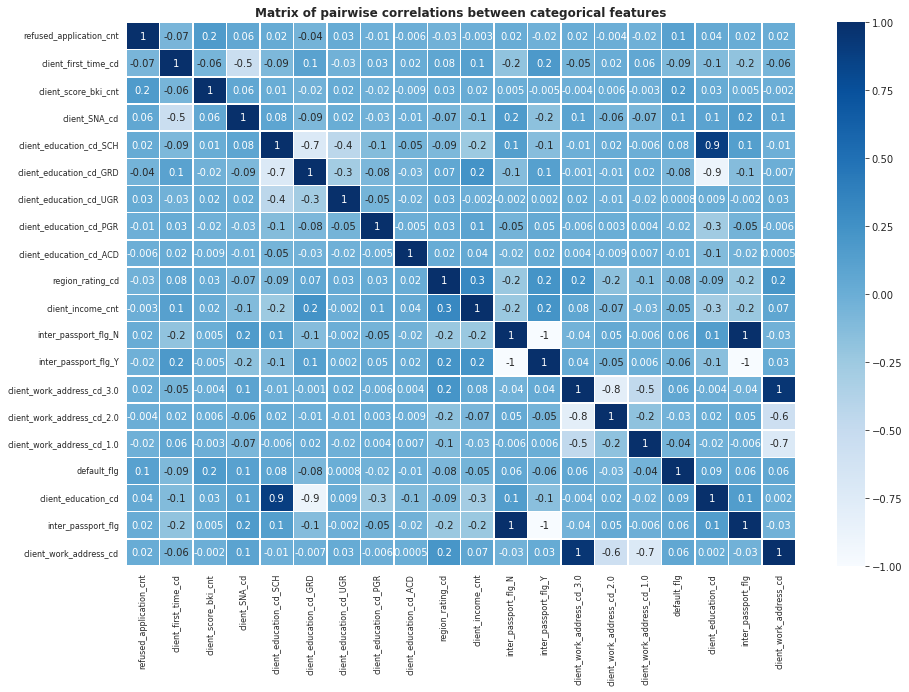

In [ ]:
plt.figure(figsize=(15, 10)) # зададим размер картинки
corr_data = X_train_prep.corr(method='pearson') # рассчитаем корреляцию
ax = sns.heatmap(corr_data, cmap=plt.cm.Blues, vmin=-1, vmax=1, center=0, annot = True, fmt ='.1g', square=False,
                 annot_kws={'size':10}, linewidths=.5) # нарисуем график
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 8)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 8)
ax.set_title("Matrix of pairwise correlations between categorical features", fontsize=12, weight='bold');
ax.set_xticklabels(['Отказанные заявки', 'Gender', 'Region raiting', 'Type of living space',
                  'Type of work', 'Connections with other clients', 'Years a client of the bank', 'Default']);
ax.set_yticklabels(['Education', 'Gender', 'Region raiting', 'Type of living space',
                  'Type of work', 'Connections with other clients', 'Years a client of the bank', 'Default']);

In [ ]:
X_train_prep.columns

Index(['refused_application_cnt', 'client_first_time_cd',
       'client_score_bki_cnt', 'client_SNA_cd', 'client_education_cd_SCH',
       'client_education_cd_GRD', 'client_education_cd_UGR',
       'client_education_cd_PGR', 'client_education_cd_ACD',
       'region_rating_cd', 'client_income_cnt', 'inter_passport_flg_N',
       'inter_passport_flg_Y', 'client_work_address_cd_3.0',
       'client_work_address_cd_2.0', 'client_work_address_cd_1.0',
       'default_flg', 'client_education_cd', 'inter_passport_flg',
       'client_work_address_cd'],
      dtype='object')

In [ ]:
X_train_prep = X_train_prep.drop(['inter_passport_flg_Y', 'client_education_cd', 'inter_passport_flg', 'client_work_address_cd_3.0'], axis=1 )

In [ ]:
X_test_prep = X_test_prep.drop(['inter_passport_flg_Y', 'client_education_cd', 'inter_passport_flg', 'client_work_address_cd_3.0'], axis=1 )

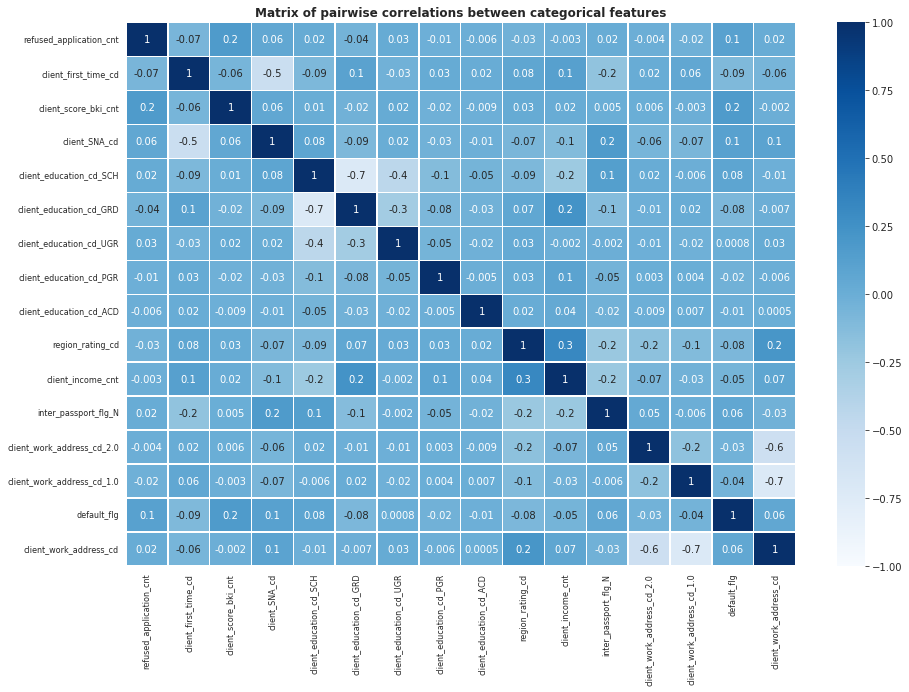

In [ ]:
plt.figure(figsize=(15, 10)) # зададим размер картинки
corr_data = X_train_prep.corr(method='pearson') # рассчитаем корреляцию
ax = sns.heatmap(corr_data, cmap=plt.cm.Blues, vmin=-1, vmax=1, center=0, annot = True, fmt ='.1g', square=False,
                 annot_kws={'size':10}, linewidths=.5) # нарисуем график
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 8)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 8)
ax.set_title("Matrix of pairwise correlations between categorical features", fontsize=12, weight='bold');
#ax.set_xticklabels(['Education', 'Gender', 'Region raiting', 'Type of living space',
 #                   'Type of work', 'Connections with other clients', 'Years a client of the bank', 'Default']);
#ax.set_yticklabels(['Education', 'Gender', 'Region raiting', 'Type of living space',
 #                   'Type of work', 'Connections with other clients', 'Years a client of the bank', 'Default']);

#Model

In [ ]:
X_train = X_train_prep.drop(columns=['default_flg'])

In [ ]:
X_test = X_test_prep.drop(columns=['default_flg'])

In [ ]:
X_train.shape

(113315, 15)

In [ ]:
y_train.shape

(113315,)

In [ ]:
X_test.columns

Index(['refused_application_cnt', 'client_first_time_cd',
       'client_score_bki_cnt', 'client_SNA_cd', 'client_education_cd_SCH',
       'client_education_cd_GRD', 'client_education_cd_UGR',
       'client_education_cd_PGR', 'client_education_cd_ACD',
       'region_rating_cd', 'client_income_cnt', 'inter_passport_flg_N',
       'client_work_address_cd_2.0', 'client_work_address_cd_1.0',
       'client_work_address_cd'],
      dtype='object')

In [ ]:
X_train.columns

Index(['refused_application_cnt', 'client_first_time_cd',
       'client_score_bki_cnt', 'client_SNA_cd', 'client_education_cd_SCH',
       'client_education_cd_GRD', 'client_education_cd_UGR',
       'client_education_cd_PGR', 'client_education_cd_ACD',
       'region_rating_cd', 'client_income_cnt', 'inter_passport_flg_N',
       'client_work_address_cd_2.0', 'client_work_address_cd_1.0',
       'client_work_address_cd'],
      dtype='object')

In [ ]:
y_test

30601     1
23455     0
91238     0
9208      0
50444     1
         ..
132601    0
39798     0
20977     1
27085     0
66499     0
Name: default_flg, Length: 48655, dtype: int64

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((113315, 15), (48655, 15), (113315,), (48655,))

## LogisticRegression

In [ ]:
log_reg = LogisticRegression(random_state=42)

In [ ]:
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [ ]:
y_pred = log_reg.predict(X_test)

In [ ]:
mi = ModelInspect(log_reg, X_test, y_test)

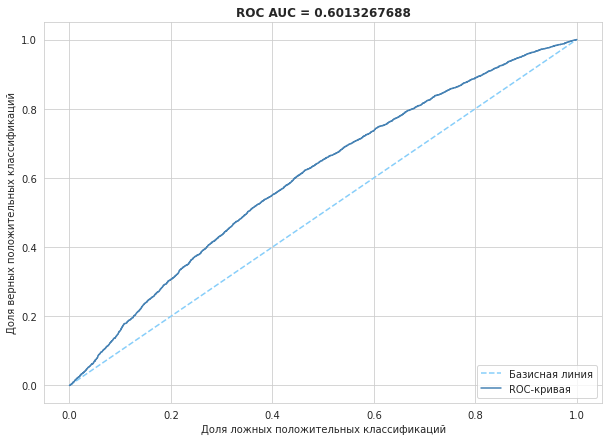

Коэффициент Джини:  0.20265353755766502


In [ ]:
mi.roc_curve_plot()

In [ ]:
mi.get_metrics()

accuracy     0.885377
precision    0.000000
recall       0.000000
F1           0.000000
ROC_AUC      0.601327
dtype: float64

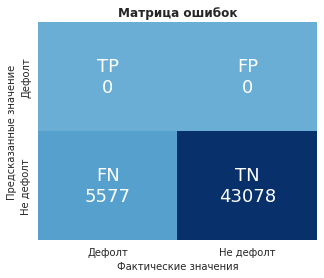

In [ ]:
mi.confusion_matrix_plot()

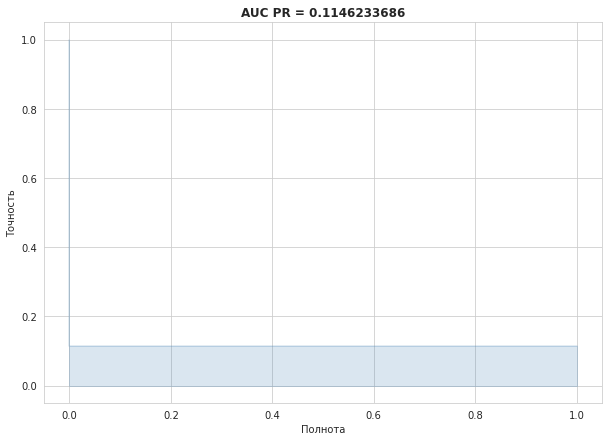

In [ ]:
mi.recall_precision_plot()

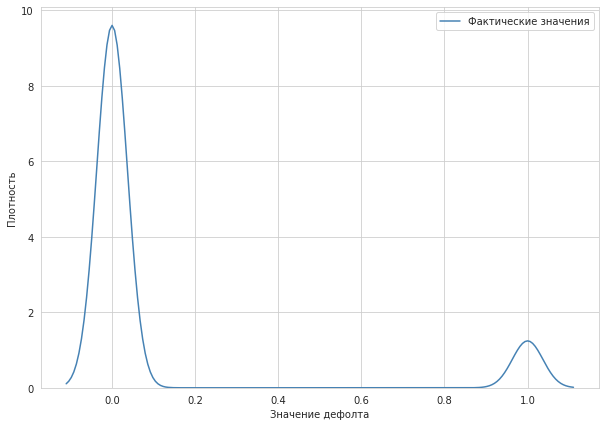

In [ ]:
plt.figure(figsize=(10, 7))
ax1 = sns.distplot(y_test, hist = False, color = 'steelblue', label = 'Фактические значения')
sns.distplot(y_pred, hist = False, color = 'lightskyblue', label = 'Предсказанные значение', ax = ax1);
ax1.legend()
plt.xlabel('Значение дефолта', fontsize=10)
plt.ylabel('Плотность', fontsize=10);

###GridSearch

In [ ]:
log_reg = LogisticRegression(random_state=42, class_weight='balanced')

In [ ]:
from scipy.stats import uniform
param_grid = {"C" : uniform(loc=0, scale=4),
        "penalty" : ["l1", "l2"],
        "solver" : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

In [ ]:
grid_logreg = RandomizedSearchCV(log_reg, param_grid, n_iter=100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [ ]:
grid_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
grid_logreg.best_params_

In [ ]:
y_pred = grid_logreg.predict(X_test)

In [ ]:
mi = ModelInspect(grid_logreg, X_test, y_test)

In [ ]:
mi.roc_curve_plot()

In [ ]:
mi.get_metrics()

In [ ]:
mi.confusion_matrix_plot()

In [ ]:
mi.recall_precision_plot()

In [ ]:
plt.figure(figsize=(10, 7))
ax1 = sns.distplot(y_test, hist = False, color = 'steelblue', label = 'Фактические значения')
sns.distplot(y_pred, hist = False, color = 'lightskyblue', label = 'Предсказанные значение', ax = ax1);
ax1.legend()
plt.xlabel('Значение дефолта', fontsize=10)
plt.ylabel('Плотность', fontsize=10);

## RandomForestClassifier

In [ ]:
rnd_frst = RandomForestClassifier(random_state=42)

In [ ]:
rnd_frst.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rnd_frst.predict(X_test)

In [ ]:
mi = ModelInspect(rnd_frst, X_test, y_test)

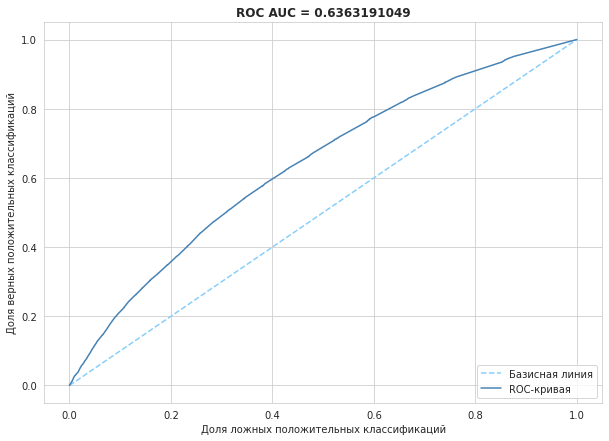

Коэффициент Джини:  0.2726382098522795


In [ ]:
mi.roc_curve_plot()

In [ ]:
mi.get_metrics()

accuracy     0.882828
precision    0.250000
recall       0.011117
F1           0.021288
ROC_AUC      0.636319
dtype: float64

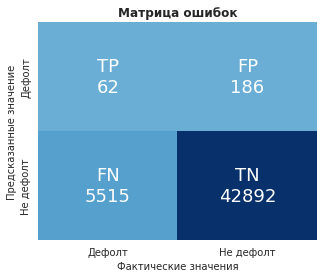

In [ ]:
mi.confusion_matrix_plot()

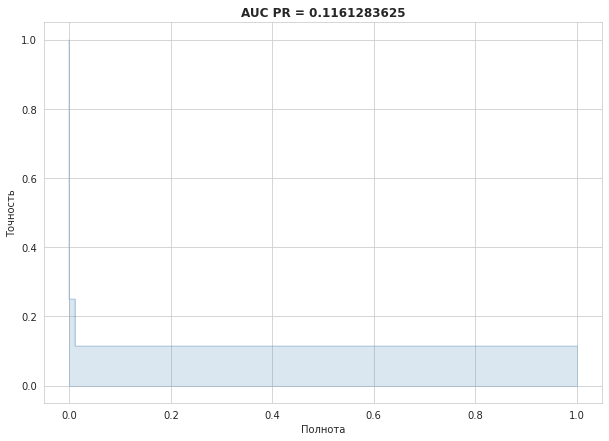

In [ ]:
mi.recall_precision_plot()

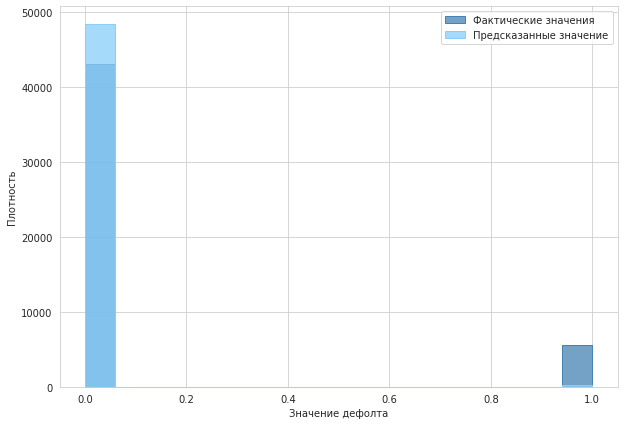

In [ ]:
plt.figure(figsize=(10, 7))
ax1 = sns.histplot(y_test, color = 'steelblue', label = 'Фактические значения', element='step')
sns.histplot(y_pred, color = 'lightskyblue', label = 'Предсказанные значение', element='step', ax = ax1);
ax1.legend()
plt.xlabel('Значение дефолта', fontsize=10)
plt.ylabel('Плотность', fontsize=10);

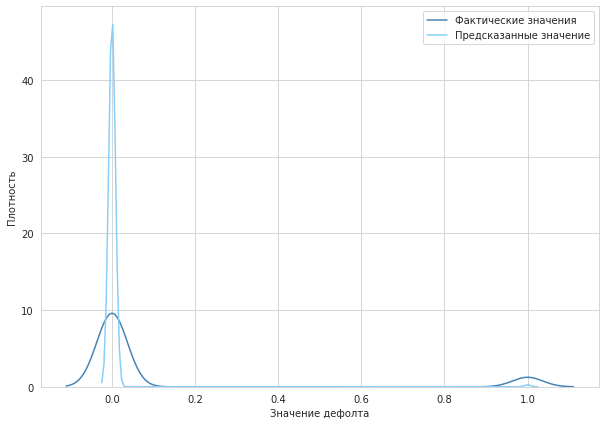

In [ ]:
plt.figure(figsize=(10, 7))
ax1 = sns.distplot(y_test, hist = False, color = 'steelblue', label = 'Фактические значения')
sns.distplot(y_pred, hist = False, color = 'lightskyblue', label = 'Предсказанные значение', ax = ax1);
ax1.legend()
plt.xlabel('Значение дефолта', fontsize=10)
plt.ylabel('Плотность', fontsize=10);

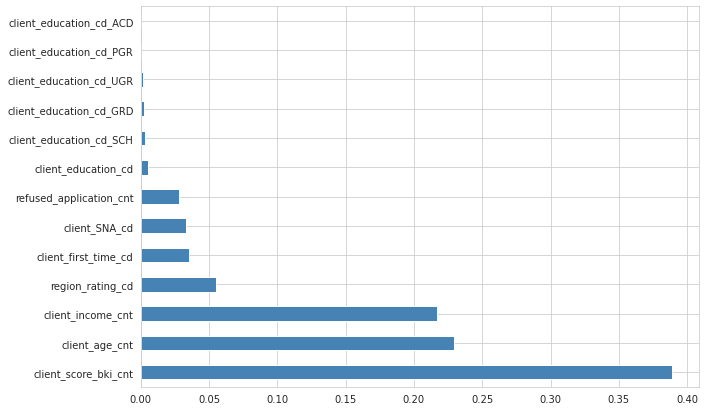

In [ ]:
plt.figure(figsize=(10,7))
feat_importances = pd.Series(rnd_frst.feature_importances_, index = X_train.columns)
feat_importances.sort_values(ascending=False).plot(kind='barh', color = 'steelblue');

###GridSearch

In [ ]:
rnd_frst = RandomForestClassifier(random_state=42, class_weight='balanced')

In [ ]:
param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 80, num = 20)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 120, num = 12)],
               'min_samples_split': range(1, 2100, 200),
               'min_samples_leaf': range(1,71,10),
               'bootstrap': [True, False]}

In [ ]:
grid_rnd_frst = RandomizedSearchCV(rnd_frst, param_grid, n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [ ]:
grid_rnd_frst.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': range(1, 71, 10),
                                        'min_samples_split': range(1, 2100, 200),
                                        'n_estimators': [1, 5, 9, 13, 17, 21,
                                                         25, 30, 34, 38, 42, 46,
                                                         50, 55, 59, 63, 67, 71,
                              

In [ ]:
grid_rnd_frst.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 201,
 'n_estimators': 38}

In [ ]:
y_pred = grid_rnd_frst.predict(X_test) 

In [ ]:
mi = ModelInspect(grid_rnd_frst, X_test, y_test)

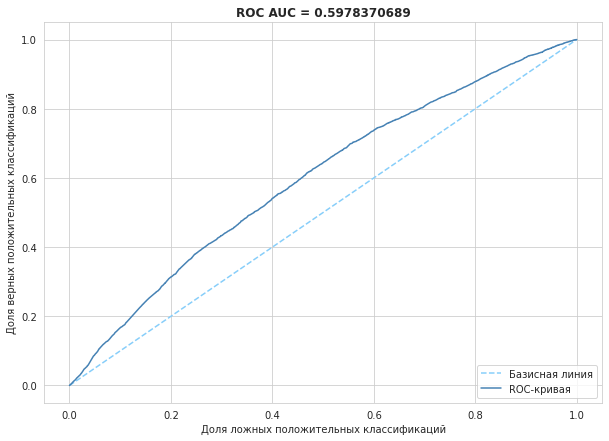

Коэффициент Джини:  0.19567413783396947


In [ ]:
mi.roc_curve_plot()

In [ ]:
mi.get_metrics()

accuracy     0.883547
precision    0.144444
recall       0.004201
F1           0.008165
ROC_AUC      0.597837
dtype: float64

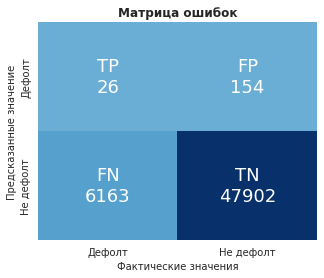

In [ ]:
mi.confusion_matrix_plot()

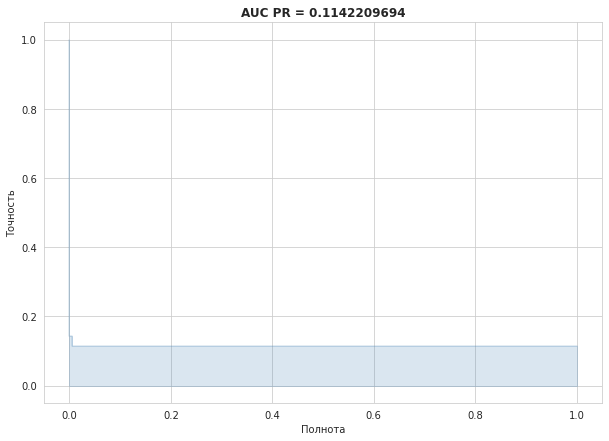

In [ ]:
mi.recall_precision_plot()

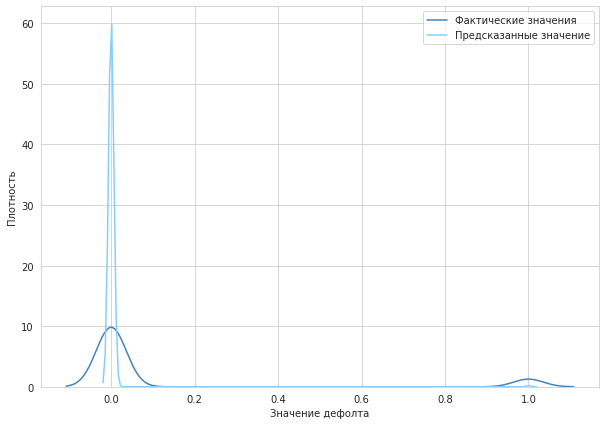

In [ ]:
plt.figure(figsize=(10, 7))
ax1 = sns.distplot(y_test, hist = False, color = 'steelblue', label = 'Фактические значения')
sns.distplot(y_pred, hist = False, color = 'lightskyblue', label = 'Предсказанные значение', ax = ax1);
ax1.legend()
plt.xlabel('Значение дефолта', fontsize=10)
plt.ylabel('Плотность', fontsize=10);

## GradientBoostingClassifier

In [ ]:
gb = GradientBoostingClassifier(random_state = 42)

In [ ]:
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [ ]:
y_pred = gb.predict(X_test)

In [ ]:
mi = ModelInspect(gb, X_test, y_test)

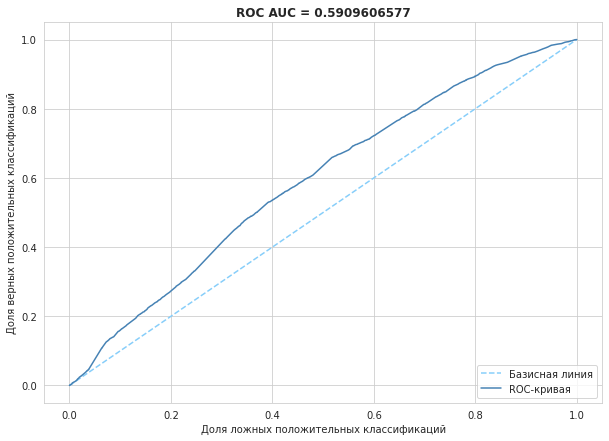

Коэффициент Джини:  0.18192131531363875


In [ ]:
mi.roc_curve_plot()

In [ ]:
mi.get_metrics()

accuracy     0.885907
precision    0.500000
recall       0.000323
F1           0.000646
ROC_AUC      0.590961
dtype: float64

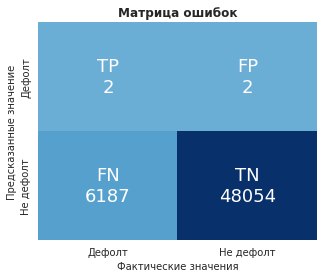

In [ ]:
mi.confusion_matrix_plot()

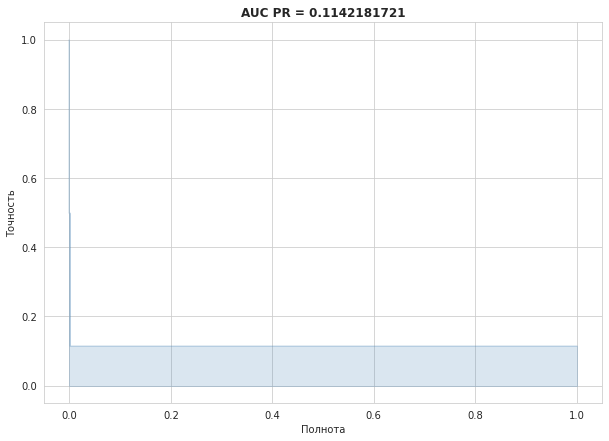

In [ ]:
mi.recall_precision_plot()

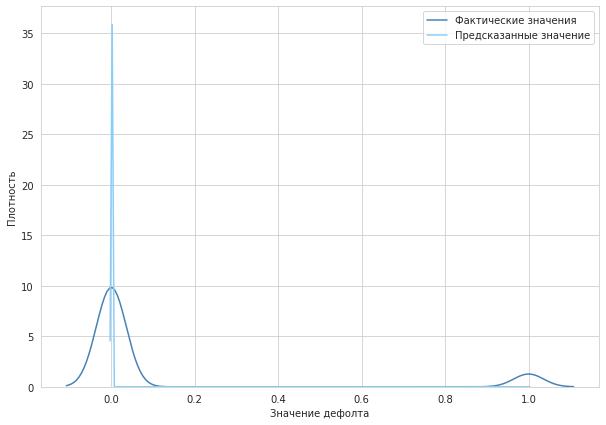

In [ ]:
plt.figure(figsize=(10, 7))
ax1 = sns.distplot(y_test, hist = False, color = 'steelblue', label = 'Фактические значения')
sns.distplot(y_pred, hist = False, color = 'lightskyblue', label = 'Предсказанные значение', ax = ax1);
ax1.legend()
plt.xlabel('Значение дефолта', fontsize=10)
plt.ylabel('Плотность', fontsize=10);

###GridSearch

In [ ]:
param_grid = {'n_estimators': range(20,81,10),
               'max_features': range(7,20,2),
               'max_depth' : range(5,16,2),
               'min_samples_split' : range(1000, 2100, 200),
               'min_samples_leaf': range(30,71,10),
               'subsample': [0.6,0.7,0.75,0.8,0.85,0.9]
              }

grid_gb = RandomizedSearchCV(gb, param_distributions = param_grid,  n_iter = 50, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [ ]:
grid_gb.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': range(5, 16, 2),
                                        'max_features': range(7, 20, 2),
                                        'min_samples_leaf': range(30, 71, 10),
                                        'min_samples_split': range(1000, 2100, 200),
                                        'n_estimators': range(20, 81, 10),
                                        'subsample': [0.6, 0.7, 0.75, 0.8, 0.85,
                                                      0.9]},
                   random_state=35, verbose=2)

In [ ]:
grid_gb.best_params_

{'max_depth': 5,
 'max_features': 9,
 'min_samples_leaf': 50,
 'min_samples_split': 1600,
 'n_estimators': 60,
 'subsample': 0.85}

In [ ]:
y_pred = grid_gb.predict(X_test)

In [ ]:
mi = ModelInspect(grid_gb, X_test, y_test)

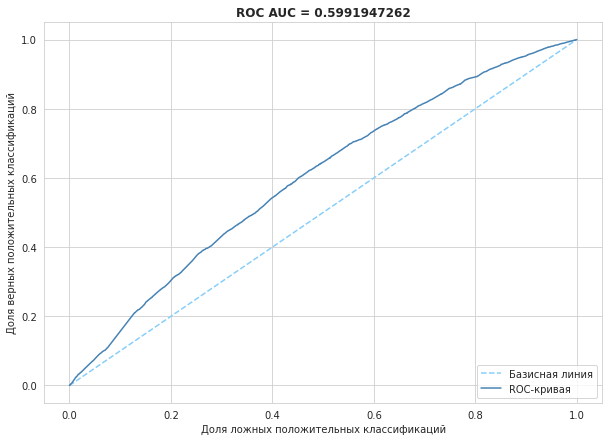

Коэффициент Джини:  0.19838945235513594


In [ ]:
mi.roc_curve_plot()

In [ ]:
mi.get_metrics()

accuracy     0.885907
precision    0.000000
recall       0.000000
F1           0.000000
ROC_AUC      0.599195
dtype: float64

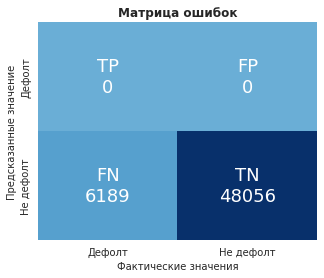

In [ ]:
mi.confusion_matrix_plot()

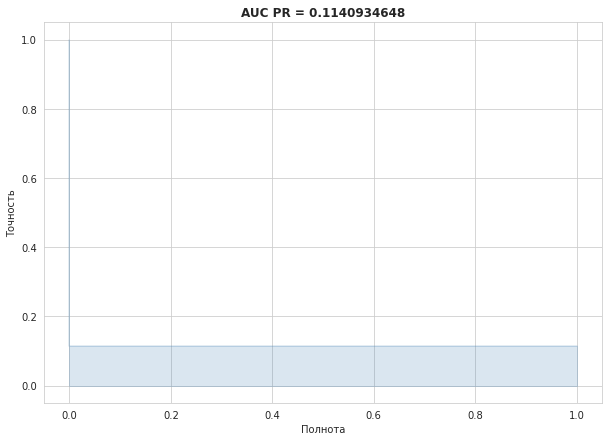

In [ ]:
mi.recall_precision_plot()

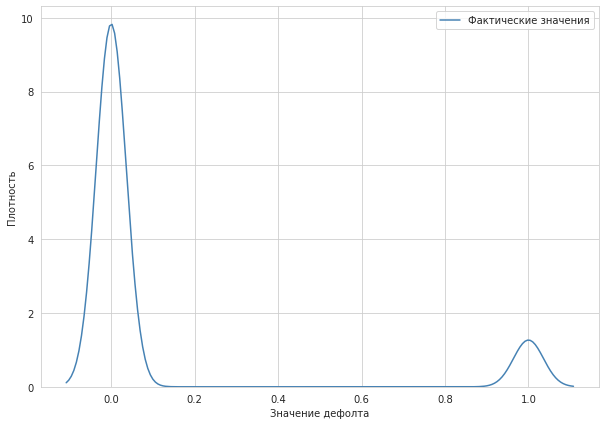

In [ ]:
plt.figure(figsize=(10, 7))
ax1 = sns.distplot(y_test, hist = False, color = 'steelblue', label = 'Фактические значения')
sns.distplot(y_pred, hist = False, color = 'lightskyblue', label = 'Предсказанные значение', ax = ax1);
ax1.legend()
plt.xlabel('Значение дефолта', fontsize=10)
plt.ylabel('Плотность', fontsize=10);

##KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
mi = ModelInspect(knn, X_test, y_test)

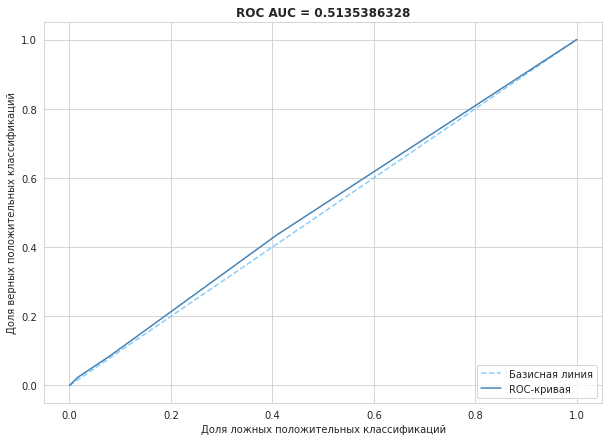

Коэффициент Джини:  0.027077265622379443


In [ ]:
mi.roc_curve_plot()

In [ ]:
mi.get_metrics()

accuracy     0.874403
precision    0.157143
recall       0.023106
F1           0.040287
ROC_AUC      0.513539
dtype: float64

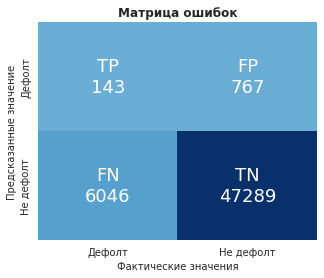

In [ ]:
mi.confusion_matrix_plot()

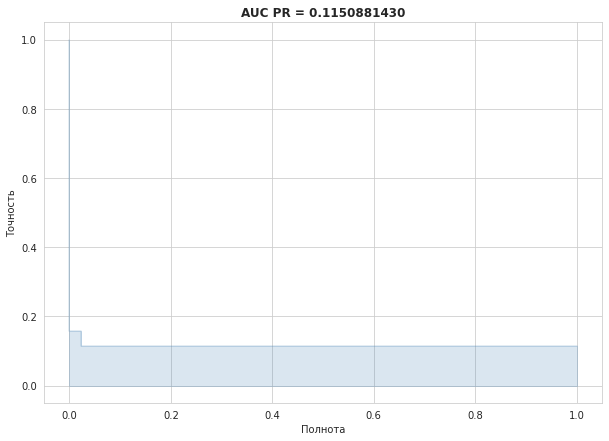

In [ ]:
mi.recall_precision_plot()

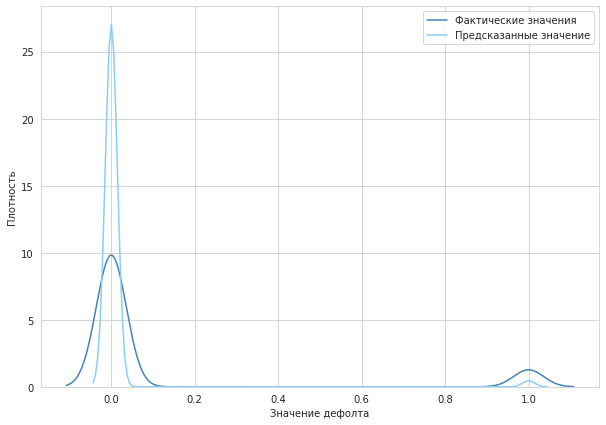

In [ ]:
plt.figure(figsize=(10, 7))
ax1 = sns.distplot(y_test, hist = False, color = 'steelblue', label = 'Фактические значения')
sns.distplot(y_pred, hist = False, color = 'lightskyblue', label = 'Предсказанные значение', ax = ax1);
ax1.legend()
plt.xlabel('Значение дефолта', fontsize=10)
plt.ylabel('Плотность', fontsize=10);

###GridSearch

In [ ]:
param_grid = {"n_neighbors"    : list(range(1,10)),
              "weights"        : ["uniform", "distance"]
             }
grid_knn = RandomizedSearchCV(knn, param_distributions = param_grid, n_iter = 10, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [ ]:
grid_knn.fit(X_train,y_train)

In [ ]:
grid_knn.best_params_

In [ ]:
y_pred = grid_knn.predict(X_test)

In [ ]:
mi = ModelInspect(grid_knn, X_test, y_test)

In [ ]:
mi.roc_curve_plot()

In [ ]:
mi.get_metrics()

In [ ]:
mi.confusion_matrix_plot()

In [ ]:
mi.recall_precision_plot()

In [ ]:
plt.figure(figsize=(10, 7))
ax1 = sns.distplot(y_test, hist = False, color = 'steelblue', label = 'Фактические значения')
sns.distplot(y_pred, hist = False, color = 'lightskyblue', label = 'Предсказанные значение', ax = ax1);
ax1.legend()
plt.xlabel('Значение дефолта', fontsize=10)
plt.ylabel('Плотность', fontsize=10);

##DecisionTreeClassifier

In [ ]:
dec_tree = DecisionTreeClassifier(random_state = 42)

In [ ]:
dec_tree.fit(X_train, y_train)

In [ ]:
y_pred = dec_tree.predict(X_test)

In [ ]:
mi = ModelInspect(dec_tree, X_test, y_test)

In [ ]:
mi.roc_curve_plot()

In [ ]:
mi.get_metrics()

In [ ]:
mi.confusion_matrix_plot()

In [ ]:
mi.recall_precision_plot()

In [ ]:
plt.figure(figsize=(10, 7))
ax1 = sns.distplot(y_test, hist = False, color = 'steelblue', label = 'Фактические значения')
sns.distplot(y_pred, hist = False, color = 'lightskyblue', label = 'Предсказанные значение', ax = ax1);
ax1.legend()
plt.xlabel('Значение дефолта', fontsize=10)
plt.ylabel('Плотность', fontsize=10);

###GridSearch

In [ ]:
param_grid = {'max_leaf_nodes': list(range(2, 100)),
              'min_samples_split': [2, 3, 4],
              'class_weight': ['balanced', 'none']
             }

In [ ]:
grid_dec_tree = RandomizedSearchCV(dec_tree, param_distributions = param_grid, n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [ ]:
grid_dec_tree.fit(X_train,y_train)

In [ ]:
grid_dec_tree.best_params_

In [ ]:
y_pred = grid_dec_tree.predict(X_test)

In [ ]:
mi = ModelInspect(grid_dec_tree, X_test, y_test)

In [ ]:
mi.roc_curve_plot()

In [ ]:
mi.get_metrics()

In [ ]:
mi.confusion_matrix_plot()

In [ ]:
mi.recall_precision_plot()

In [ ]:
plt.figure(figsize=(10, 7))
ax1 = sns.distplot(y_test, hist = False, color = 'steelblue', label = 'Фактические значения')
sns.distplot(y_pred, hist = False, color = 'lightskyblue', label = 'Предсказанные значение', ax = ax1);
ax1.legend()
plt.xlabel('Значение дефолта', fontsize=10)
plt.ylabel('Плотность', fontsize=10);